## **Install PySpark**

In [ ]:
!pip install pyspark
!pip install findspark
# Alternatively, if you want to install a specific version of pyspark:
#!pip install pyspark==3.2.1 

     |████████████████████████████████| 281.4 MB 30 kB/s 
     |████████████████████████████████| 198 kB 50.6 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=cd5c2c36281ede9ffeb91a3e4ffc20a0dbb4fe866236b722da7d5c902211d46e
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


## **Import all the useful packages**

In [ ]:
from tqdm import tqdm

import requests
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
import pyspark.sql.functions as f
#from pyspark.sql.functions import split, regexp_replace, year, month, dayofmonth, to_timestamp

from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler, Normalizer, Bucketizer
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, MultilayerPerceptronClassifier
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, ClusteringEvaluator 

from pyspark.mllib.feature import HashingTF, IDF

# Basic libreries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from yellowbrick.target import FeatureCorrelation
from sklearn.preprocessing import OrdinalEncoder

## **Configuration of PySpark and check**

In [ ]:
# Create the session
conf = SparkConf().set("spark.ui.port", "4050").set('spark.executor.memory', '4G').set('spark.driver.memory', '45G').set('spark.driver.maxResultSize', '10G')

# Create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")

DataFrame[key: string, value: string]

In [ ]:
spark

## **Data Acquisition**

### Mount Google Drive point

In [ ]:
GDRIVE_DIR = "/content/gdrive" # Your own mount point on Google Drive
GDRIVE_HOME_DIR = GDRIVE_DIR + "/My Drive" # Your own home directory
GDRIVE_DATA_DIR = GDRIVE_HOME_DIR +  "/Sapienza/Primo Anno/Big Data Computing/Project"

# Point Colaboratory to our Google Drive
from google.colab import drive

drive.mount(GDRIVE_DIR, force_remount=True)

DATASET_URL = "https://raw.githubusercontent.com/AndreaBe99/big-data-project/main/data/dataframe.csv"
GDRIVE_DATASET_FILE = GDRIVE_DATA_DIR + "/" + DATASET_URL.split("/")[-1]

Mounted at /content/gdrive


### Retrieving Dataset and stored it

In [ ]:
import requests

"""
This function downloads a file from a specific URL directly to Google Drive.
"""
def get_data(dataset_url, dest, chunk_size=1024):
  response = requests.get(dataset_url, stream=True)
  if response.status_code == 200: # Test if everything went ok
    with open(dest, "wb") as file:
      for block in response.iter_content(chunk_size=chunk_size): 
        if block: 
          file.write(block)

In [ ]:
print("Retrieving dataset from URL: {} ...".format(DATASET_URL))
get_data(DATASET_URL, GDRIVE_DATASET_FILE)
print("Dataset successfully retrieved and stored at: {}".format(GDRIVE_DATASET_FILE))

Retrieving dataset from URL: https://raw.githubusercontent.com/AndreaBe99/big-data-project/main/data/dataframe.csv ...
Dataset successfully retrieved and stored at: /content/gdrive/My Drive/Sapienza/Primo Anno/Big Data Computing/Project/dataframe.csv


### Read DataSet file into PySpark dataframe

In [ ]:
spotify_tracks = spark.read.load(GDRIVE_DATASET_FILE, 
                           format="csv", 
                           sep=";", 
                           inferSchema="true", 
                           header="true")

In [ ]:
spotify_tracks.cache()

DataFrame[id: string, track_name: string, track_explicit: boolean, track_popularity: int, album_name: string, album_release_date: string, album_release_date_precision: string, artist_name: string, audio_avg_pitches: string, audio_avg_timbre: string, audio_acousticness: double, audio_danceability: double, audio_duration_ms: int, audio_energy: double, audio_instrumentalness: double, audio_key_1: int, audio_liveness: double, audio_loudness: double, audio_mode_1: int, audio_speechiness: double, audio_tempo: double, audio_time_signature: int, audio_valence: double, track_uri: string, track_genre: string]

### Check the shape of the loaded dataset, i.e., number of rows and columns

In [ ]:
print("The shape of the dataset is {:d} rows by {:d} columns".format(spotify_tracks.count(), len(spotify_tracks.columns)))

The shape of the dataset is 79339 rows by 25 columns


### Print out the schema of the loaded dataset

In [ ]:
spotify_tracks.printSchema()

root
 |-- id: string (nullable = true)
 |-- track_name: string (nullable = true)
 |-- track_explicit: boolean (nullable = true)
 |-- track_popularity: integer (nullable = true)
 |-- album_name: string (nullable = true)
 |-- album_release_date: string (nullable = true)
 |-- album_release_date_precision: string (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- audio_avg_pitches: string (nullable = true)
 |-- audio_avg_timbre: string (nullable = true)
 |-- audio_acousticness: double (nullable = true)
 |-- audio_danceability: double (nullable = true)
 |-- audio_duration_ms: integer (nullable = true)
 |-- audio_energy: double (nullable = true)
 |-- audio_instrumentalness: double (nullable = true)
 |-- audio_key_1: integer (nullable = true)
 |-- audio_liveness: double (nullable = true)
 |-- audio_loudness: double (nullable = true)
 |-- audio_mode_1: integer (nullable = true)
 |-- audio_speechiness: double (nullable = true)
 |-- audio_tempo: double (nullable = true)
 |-- audio

# **Dataset Shape**

## **Print the 5 rows of the load dataset**

In [ ]:
spotify_tracks.show(5)

+--------------------+-----------------+--------------+----------------+--------------------+------------------+----------------------------+---------------+--------------------+--------------------+------------------+------------------+-----------------+------------+----------------------+-----------+--------------+--------------+------------+-----------------+-----------+--------------------+-------------+--------------------+-----------+
|                  id|       track_name|track_explicit|track_popularity|          album_name|album_release_date|album_release_date_precision|    artist_name|   audio_avg_pitches|    audio_avg_timbre|audio_acousticness|audio_danceability|audio_duration_ms|audio_energy|audio_instrumentalness|audio_key_1|audio_liveness|audio_loudness|audio_mode_1|audio_speechiness|audio_tempo|audio_time_signature|audio_valence|           track_uri|track_genre|
+--------------------+-----------------+--------------+----------------+--------------------+-----------------

In [ ]:
# Drop duplicates and split the columns using PySpark
spotify_tracks = spotify_tracks.dropDuplicates()

# **Clear and Organize the Dataset**

In [ ]:
# We build a Function to manipulate the database more time, one for the original dtaset and one for the playlist dataset

def split_array_columns(data, col_name, new_col_name):
  """
    Input:
     - data: it is the dataset,
     - col_name: name of the column that we will split
     - new_col_name: name of the new columns
  """

  # Split String audio_avg_pitches to n columns

  # Delete the '[]'
  temp_name = col_name+'_list'
  data = data.select(data.columns + [f.translate(f.col(col_name), "[]", "").alias(temp_name)])

  split_col = split(data[temp_name], ', ')
  # Split the string into new columns and cast it to double
  for i in range(12):
    
    data = data.withColumn(new_col_name+str(i), split_col.getItem(i))

    i_name = new_col_name+str(i)
    # Cast converted columns
    #data = data.withColumn(i_name, col(i_name).cast('double'))
    data = data.withColumn(i_name, data[i_name].cast("double"))
    #data.select(col(new_col_name+str(i)).cast('double').alias(new_col_name+str(i)))
  
  # Drop unless columns
  cols_to_drop = (col_name, col_name+"_list")
  data = data.drop(*cols_to_drop)

  return data

In [ ]:
def to_date_(col, formats=("yyyy-MM-dd", "y")):
    # Spark 2.2 or later syntax, for < 2.2 use unix_timestamp and cast
    return coalesce(*[to_date(col, f) for f in formats])

def split_date(data, col_name):

  # Convert to date format
  data = data.withColumn(col_name+"_td", to_date_(col_name))

  # Split date to columns
  temp_name = col_name+'_td'
  data = data.withColumn('day', dayofmonth(data[temp_name]))
  data = data.withColumn('month', month(data[temp_name]))
  data = data.withColumn('year', year(data[temp_name]))

  # cast to int type
  data = data.withColumn("year", data.year.cast('int'))\
              .withColumn("day", data.day.cast('int'))\
              .withColumn("month", data.month.cast('int'))

  # Drop unless columns
  cols_to_drop = (col_name, col_name+"_td")
  data = data.drop(*cols_to_drop)

  return data

In [ ]:
spotify_tracks_splitted = split_array_columns(spotify_tracks, "audio_avg_pitches", "pitch_")
spotify_tracks_splitted = split_array_columns(spotify_tracks_splitted, "audio_avg_timbre", "timbre_")
del spotify_tracks

spotify_tracks = split_date(spotify_tracks_splitted, "album_release_date")
del spotify_tracks_splitted

In [ ]:
spotify_tracks.printSchema()

root
 |-- id: string (nullable = true)
 |-- track_name: string (nullable = true)
 |-- track_explicit: boolean (nullable = true)
 |-- track_popularity: integer (nullable = true)
 |-- album_name: string (nullable = true)
 |-- album_release_date_precision: string (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- audio_acousticness: double (nullable = true)
 |-- audio_danceability: double (nullable = true)
 |-- audio_duration_ms: integer (nullable = true)
 |-- audio_energy: double (nullable = true)
 |-- audio_instrumentalness: double (nullable = true)
 |-- audio_key_1: integer (nullable = true)
 |-- audio_liveness: double (nullable = true)
 |-- audio_loudness: double (nullable = true)
 |-- audio_mode_1: integer (nullable = true)
 |-- audio_speechiness: double (nullable = true)
 |-- audio_tempo: double (nullable = true)
 |-- audio_time_signature: integer (nullable = true)
 |-- audio_valence: double (nullable = true)
 |-- track_uri: string (nullable = true)
 |-- track_genre: 

## Look and delete possible Null Value

In [ ]:
# null values in each column
spotify_tracks.agg(*[f.count(f.when(f.isnull(c), c)).alias(c) for c in spotify_tracks.columns]).show()

+---+----------+--------------+----------------+----------+----------------------------+-----------+------------------+------------------+-----------------+------------+----------------------+-----------+--------------+--------------+------------+-----------------+-----------+--------------------+-------------+---------+-----------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+---------+---+-----+----+
| id|track_name|track_explicit|track_popularity|album_name|album_release_date_precision|artist_name|audio_acousticness|audio_danceability|audio_duration_ms|audio_energy|audio_instrumentalness|audio_key_1|audio_liveness|audio_loudness|audio_mode_1|audio_speechiness|audio_tempo|audio_time_signature|audio_valence|track_uri|track_genre|pitch_0|pitch_1|pitch_2|pitch_3|pitch_4|pitch_5|pitch_6|pitch_7|pitch_8|pitch_9|pitch_10|pitch_11|timbre_0|t

In [ ]:
spotify_tracks = spotify_tracks.dropna()

# **Data Exploration**

In this section of the notebook, we're going to show some graphics, i.e. the correlation map of the feaure, the most famous tracks, the most famous artists and so on.

In [ ]:
# To access plotting libraries, we need to first transform our PySpark DataFrame into a Pandas DataFrame
spotify_tracks_pd = spotify_tracks.toPandas() 

## Function to invert dict used to map the genres

### Import dict to map genre

In [ ]:
GDRIVE_DIR = "/content/gdrive" # Your own mount point on Google Drive
GDRIVE_HOME_DIR = GDRIVE_DIR + "/My Drive" # Your own home directory
GDRIVE_DATA_DIR = GDRIVE_HOME_DIR +  "/Sapienza/Primo Anno/Big Data Computing/Project"

drive.mount(GDRIVE_DIR, force_remount=True)

JSON_GENRE_URL = "https://raw.githubusercontent.com/AndreaBe99/big-data-project/main/data/map_genre_small.json"
GDRIVE_JSON_GENRE_FILE = GDRIVE_DATA_DIR + "/" + DATASET_URL.split("/")[-1]

def get_data(dataset_url, dest, chunk_size=1024):
  response = requests.get(dataset_url, stream=True)
  if response.status_code == 200: # Test if everything went ok
    with open(dest, "wb") as file:
      for block in response.iter_content(chunk_size=chunk_size): 
        if block: 
          file.write(block)

print("Retrieving dataset from URL: {} ...".format(JSON_GENRE_URL))
get_data(JSON_GENRE_URL, GDRIVE_JSON_GENRE_FILE)
print("Dataset successfully retrieved and stored at: {}".format(GDRIVE_JSON_GENRE_FILE))

Mounted at /content/gdrive
Retrieving dataset from URL: https://raw.githubusercontent.com/AndreaBe99/big-data-project/main/data/map_genre_small.json ...
Dataset successfully retrieved and stored at: /content/gdrive/My Drive/Sapienza/Primo Anno/Big Data Computing/Project/dataframe.csv


### Function to invert the key

In [ ]:
def invert_dict(): 
    # Reverse json 

    import json

    f = open(GDRIVE_JSON_GENRE_FILE)
    d = json.load(f)
    f.close()

    inverse = dict() 
    for key in d: 
        # Go through the list that is saved in the dict:
        for item in d[key]:
            # Check if in the inverted dict the key exists
            if item not in inverse: 
                # If not create a new list
                inverse[item] = key 
            #else: 
            #    inverse[item].append(key) 
    return inverse

## Visualization of Variability for some columns in the dataframe

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

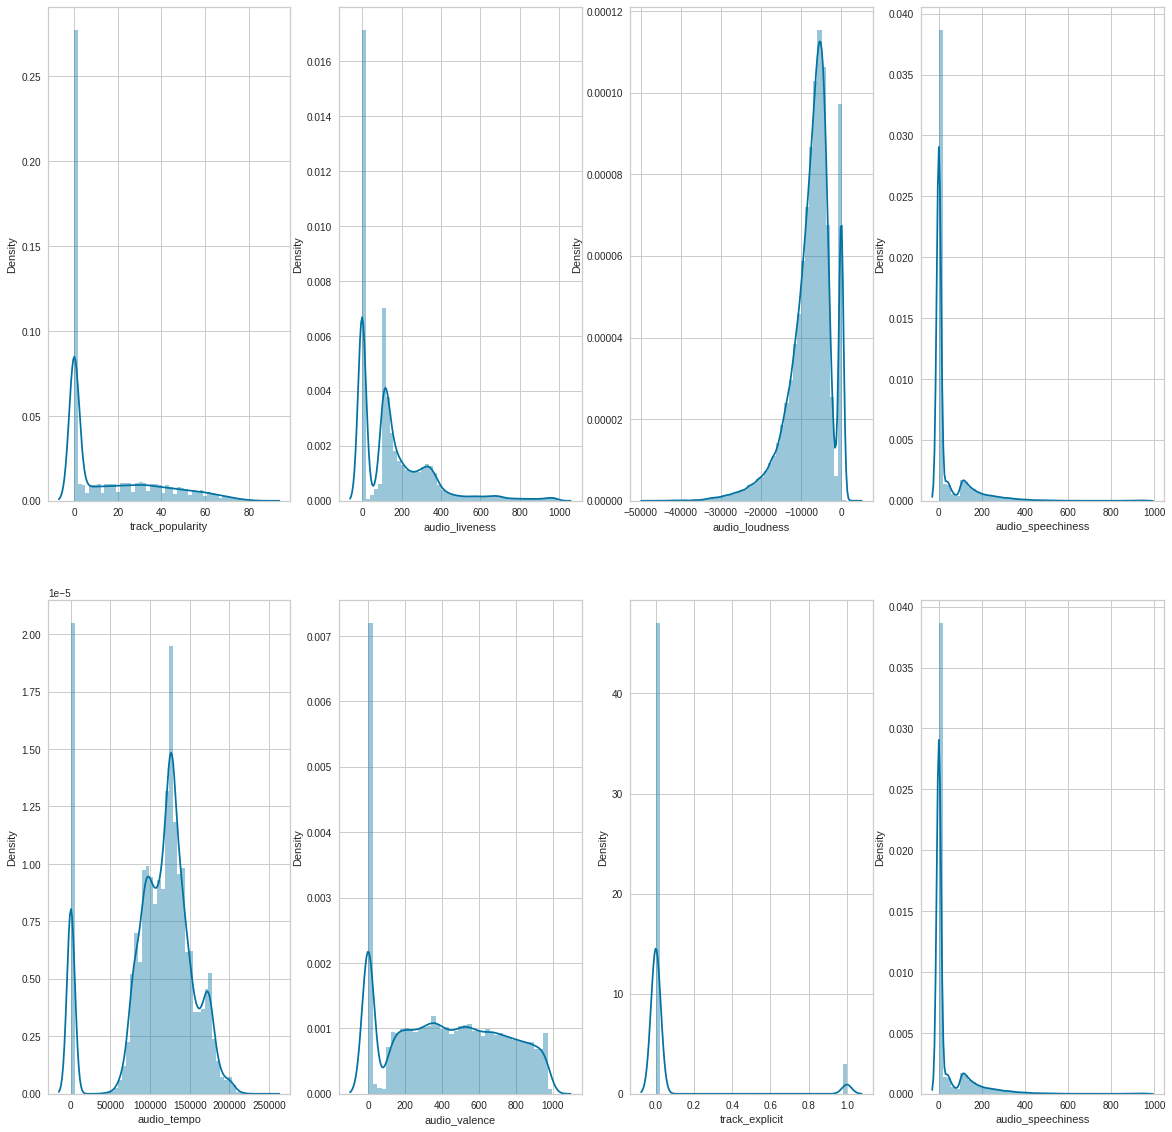

In [ ]:
#Visualisation of Variability for some columns in the dataframe
fig,ax = plt.subplots(2,4,figsize=(20,20))

sns.distplot(spotify_tracks_pd['track_popularity'],ax=ax[0,0])
sns.distplot(spotify_tracks_pd['audio_liveness'],ax=ax[0,1])
sns.distplot(spotify_tracks_pd['audio_loudness'],ax=ax[0,2])
sns.distplot(spotify_tracks_pd['audio_speechiness'],ax=ax[0,3])
sns.distplot(spotify_tracks_pd['audio_tempo'],ax=ax[1,0])
sns.distplot(spotify_tracks_pd['audio_valence'],ax=ax[1,1])
sns.distplot(spotify_tracks_pd['track_explicit'],ax=ax[1,2])
sns.distplot(spotify_tracks_pd['audio_speechiness'],ax=ax[1,3])

## Correlation Map

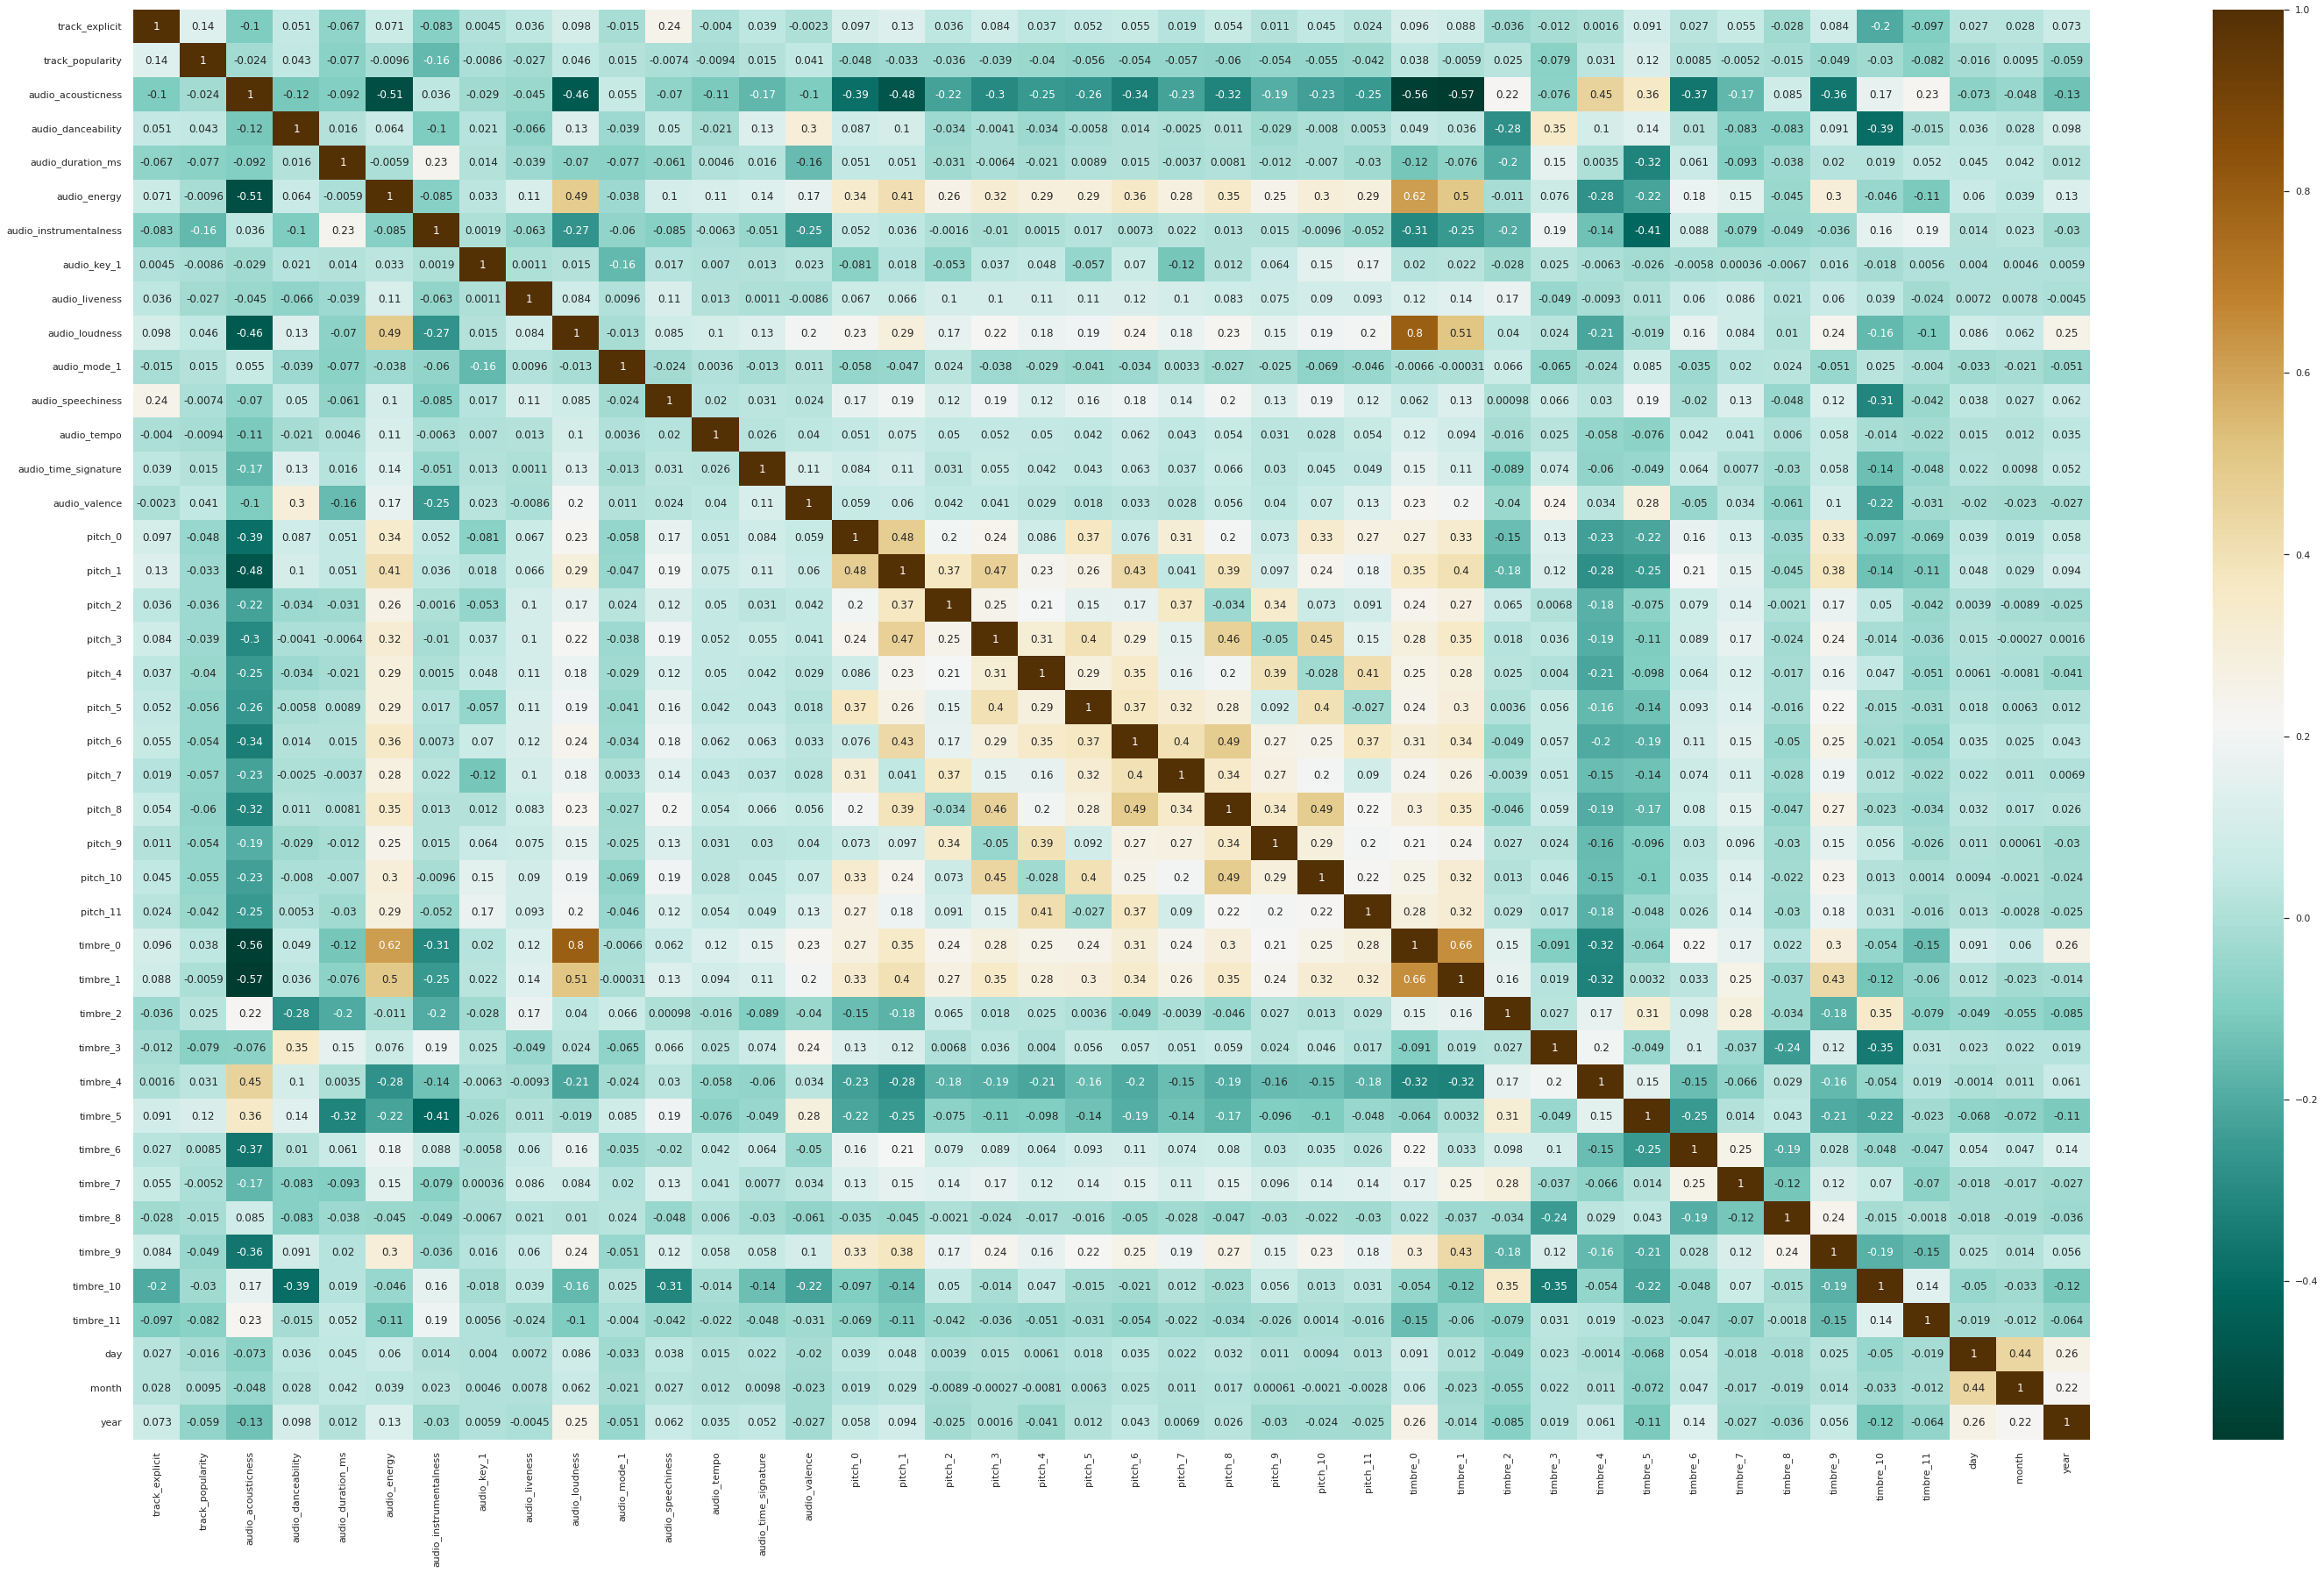

In [ ]:
plt.figure(figsize=(50,30))
sns.set(style="whitegrid")
corr = spotify_tracks_pd.corr()
sns.heatmap(corr,annot=True,cmap='BrBG_r',annot_kws={"fontsize":12})

As we can see from the correlation map that there are no highly correlated features so for now it is not necessary to drop any columns.

## Most Popular Tracks

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([  0.,  20.,  40.,  60.,  80., 100.]),
 <a list of 6 Text major ticklabel objects>)

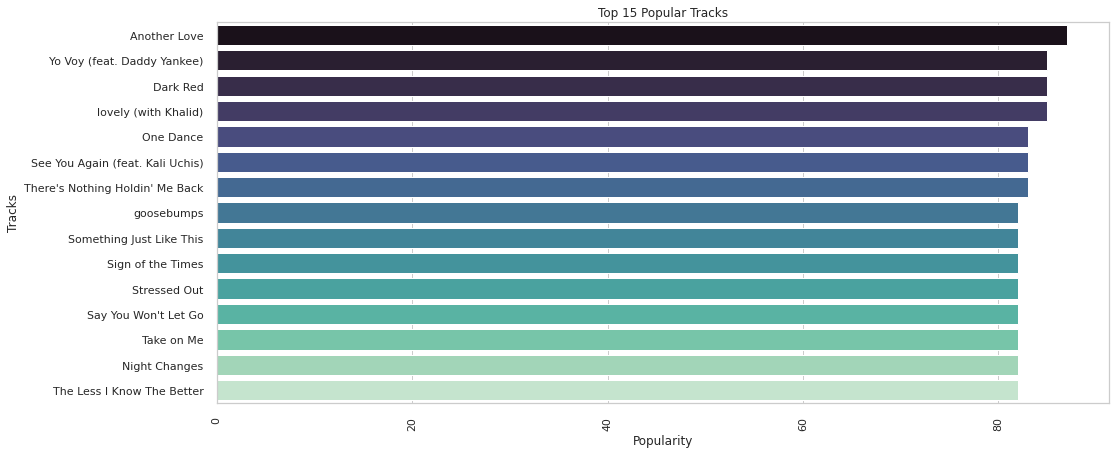

In [ ]:
#Most Popular Tracks
fig, axis = plt.subplots(figsize = (16,7))
popular = spotify_tracks_pd.groupby("track_name")['track_popularity'].mean().sort_values(ascending=False).head(15)
axis = sns.barplot(popular,popular.index,palette="mako",orient = 'h')
axis.set_title('Top 15 Popular Tracks')
axis.set_ylabel('Tracks')
axis.set_xlabel('Popularity')
plt.xticks(rotation = 90)

## Most Popular Artists

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([   0., 1000., 2000., 3000., 4000., 5000.]),
 <a list of 6 Text major ticklabel objects>)

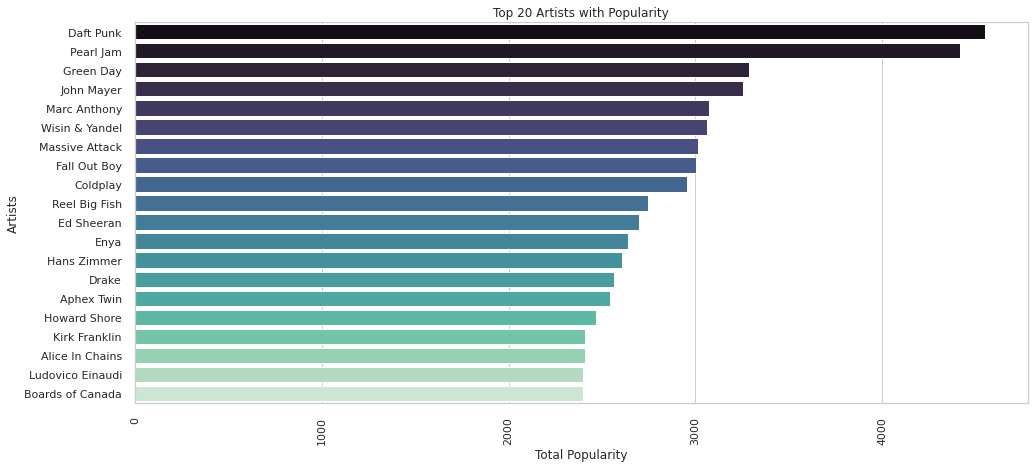

In [ ]:
#Most Popular Artists
fig, axis = plt.subplots(figsize = (16,7))
popular = spotify_tracks_pd.groupby("artist_name")['track_popularity'].sum().sort_values(ascending=False)[:20]
axis = sns.barplot(popular,popular.index,palette="mako",orient = 'h')
axis.set_title('Top 20 Artists with Popularity')
axis.set_ylabel('Artists')
axis.set_xlabel('Total Popularity')
plt.xticks(rotation = 90)

## Most present Artist

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([  0.,  25.,  50.,  75., 100., 125., 150., 175., 200.]),
 <a list of 9 Text major ticklabel objects>)

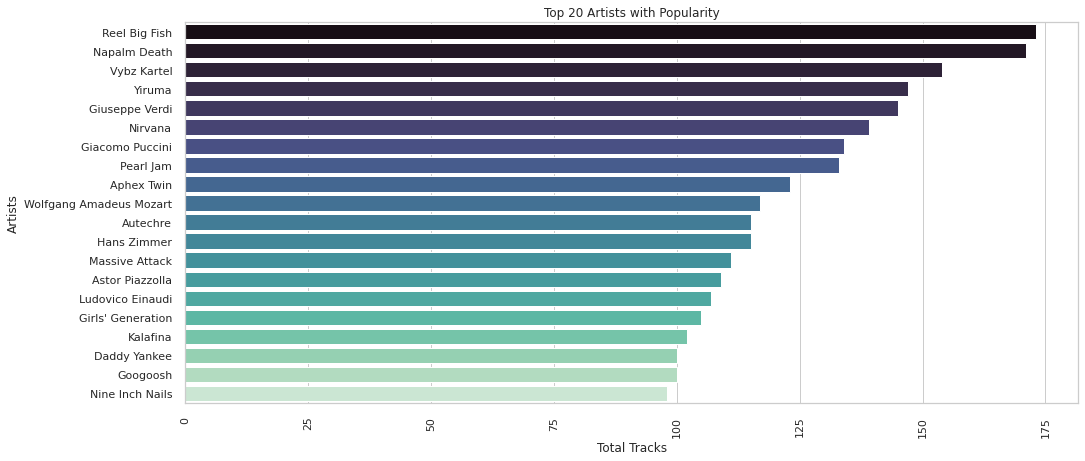

In [ ]:
#Most Popular Artists
fig, axis = plt.subplots(figsize = (16,7))
popular = spotify_tracks_pd["artist_name"].value_counts()[:20]
#popular.columns = ['feature','nunique']
#axis = sns.barplot(x='feature', y='nunique', data=popular, palette="mako")
axis = sns.barplot(popular, popular.index, palette="mako",orient = 'h')
axis.set_title('Top 20 Artists with Popularity')
axis.set_ylabel('Artists')
axis.set_xlabel('Total Tracks')
plt.xticks(rotation = 90)

## Number of songs released Year Wise

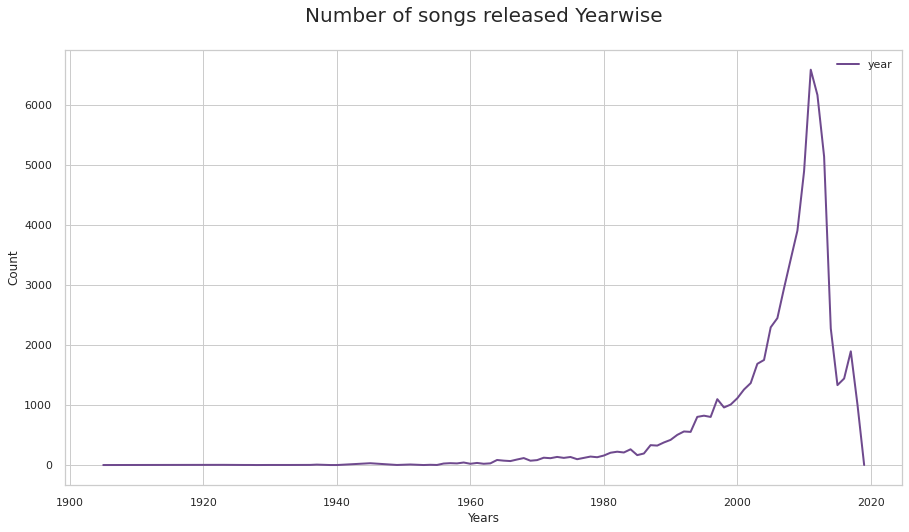

In [ ]:
year = pd.DataFrame(spotify_tracks_pd['year'].value_counts())
year = year.sort_index()
ax=year.plot(kind='line',figsize=(15,8) ,color='#6f4a8e', linewidth=2)
plt.title("Number of songs released Yearwise",y=1.05,fontsize=20)
plt.xlabel('Years')
plt.ylabel('Count')
ax.axes.get_xaxis().set_visible(True)

## Year VS Popularity

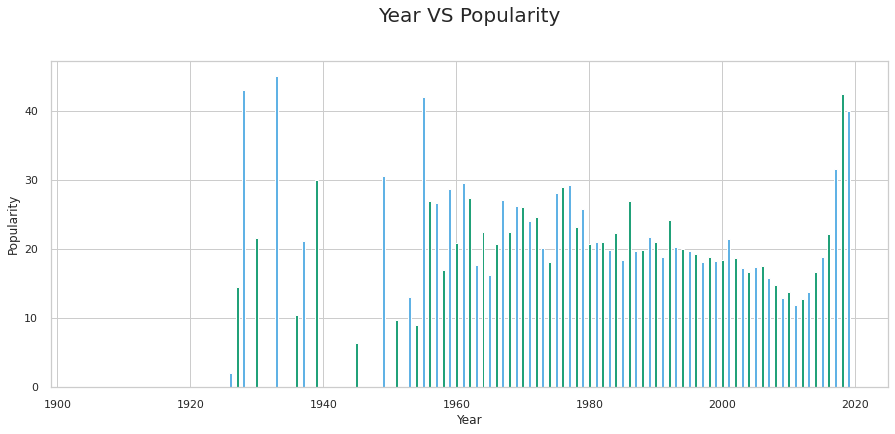

In [ ]:
keypop = pd.DataFrame(spotify_tracks_pd.groupby('year')['track_popularity'].mean()).reset_index()

fig = plt.figure(figsize=(15,6))
plt.bar( keypop['year'],
         keypop['track_popularity'],
         width=0.45,
         color = ['#60B2E5','#21A179'])
plt.title('Year VS Popularity',y=1.1,fontsize=20)
plt.xlabel('Year')
plt.ylabel('Popularity')
ax.axes.get_xaxis().set_visible(True)

## Danceability VS Popularity

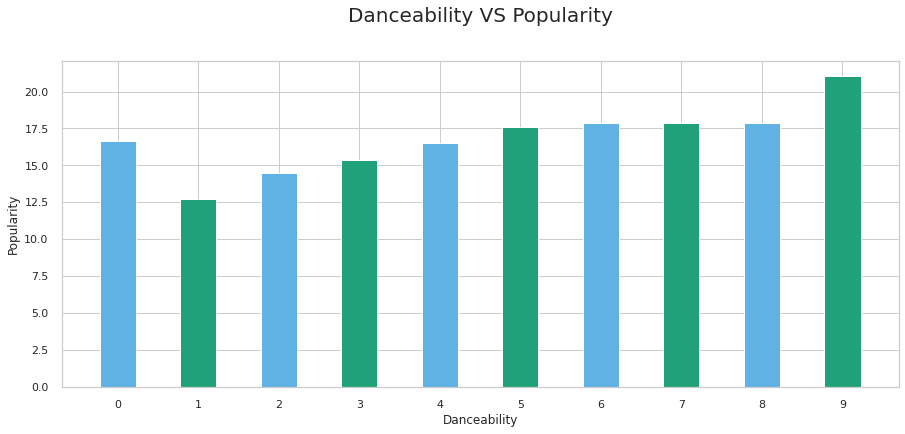

In [ ]:
bins = [i for i in range(0, 1001, 100)]
names = [str(i) for i in range(10)]

spotify_tracks_pd['audio_danceability_map'] = pd.cut(spotify_tracks_pd['audio_danceability'], bins, labels=names)

keypop = pd.DataFrame(spotify_tracks_pd.groupby('audio_danceability_map')['track_popularity'].mean()).reset_index()

fig = plt.figure(figsize=(15,6))
plt.bar( keypop['audio_danceability_map'],
         keypop['track_popularity'],
         width=0.45,
         color = ['#60B2E5','#21A179'])
plt.title('Danceability VS Popularity',y=1.1,fontsize=20)
plt.xlabel('Danceability')
plt.ylabel('Popularity')
ax.axes.get_xaxis().set_visible(True)

We can see that as danceability increases, so does popularity except for the 0 value, perhaps because Spotify sets it as the default if it doesn't have enough information.

## Key VS Popularity

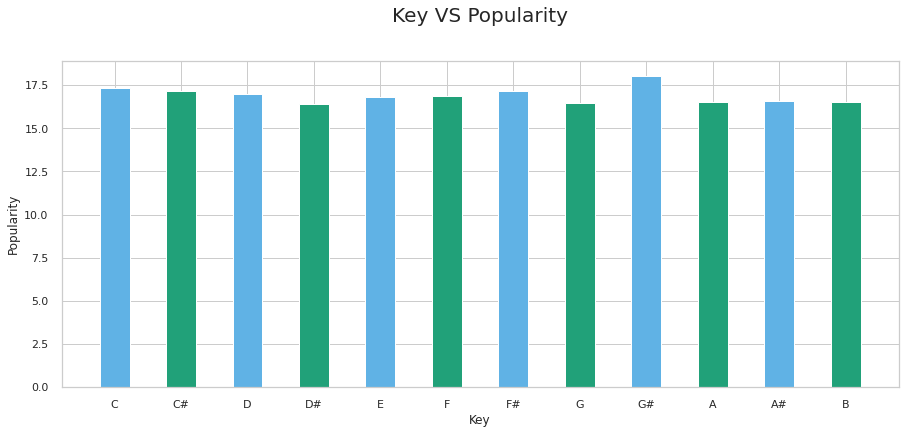

In [ ]:
keypop = pd.DataFrame(spotify_tracks_pd.groupby('audio_key_1')['track_popularity'].mean()).reset_index()
keypop.replace({'audio_key_1' : { 0 : 'C', 1 : 'C#', 2 : 'D', 3 : 'D#', 4 : 'E', 5 : 'F', 6 : 'F#', 
                        7 : 'G', 8 : 'G#', 9 : 'A', 10 : 'A#', 11 : 'B'}} , inplace=True)

fig = plt.figure(figsize=(15,6))
plt.bar( keypop['audio_key_1'],
         keypop['track_popularity'],
         width=0.45,
         color = ['#60B2E5','#21A179'])
plt.title('Key VS Popularity',y=1.1,fontsize=20)
plt.xlabel('Key')
plt.ylabel('Popularity')
ax.axes.get_xaxis().set_visible(True)

## Key VS Genre

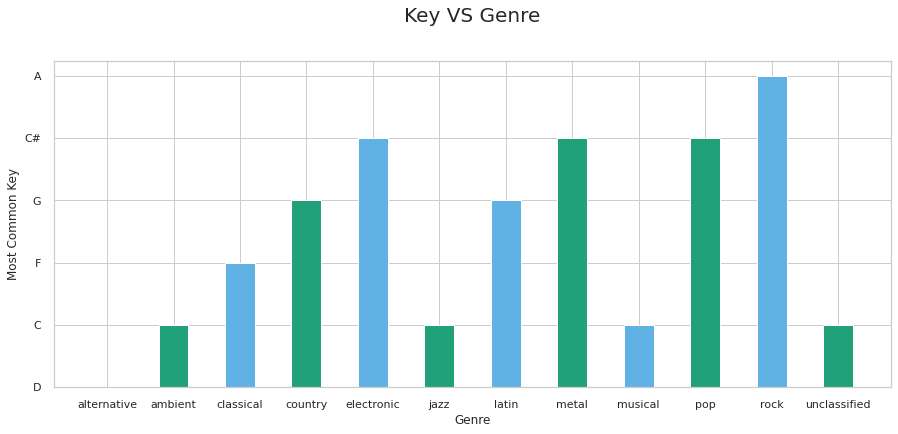

In [ ]:
map_genre_inv = invert_dict()

key_genre = pd.DataFrame(spotify_tracks_pd)
key_genre["track_genre"].replace(map_genre_inv, inplace=True)
key_genre.replace({'audio_key_1' : { 0 : 'C', 1 : 'C#', 2 : 'D', 3 : 'D#', 4 : 'E', 5 : 'F', 6 : 'F#', 
                        7 : 'G', 8 : 'G#', 9 : 'A', 10 : 'A#', 11 : 'B'}} , inplace=True)

# Aggregate most common key by genre
key_genre = key_genre.groupby(['track_genre'])['audio_key_1'].agg(pd.Series.mode)

# set column name
key_genre = pd.DataFrame({"track_genre":key_genre.index, "audio_key_1":key_genre.values})

# Some genre have more than one key
key_list = []
for key in key_genre["audio_key_1"].values:
  if type(key) == str:
    key_list.append(key)
    
  else:
    key_list.append(key[0])

fig = plt.figure(figsize=(15,6))
plt.bar( key_genre["track_genre"],
         key_list,
         width=0.45,
         color = ['#60B2E5','#21A179'])
plt.title('Key VS Genre',y=1.1,fontsize=20)
plt.xlabel('Genre')
plt.ylabel('Most Common Key')
ax.axes.get_xaxis().set_visible(True)


In [ ]:
del spotify_tracks_pd

# Discretize

## Discretize the Genres

In [ ]:
if map_genre_inv == {}:
  map_genre_inv = invert_dict()

In [ ]:
# Map the 126 genres to 12 Big-Genres from the dict file
udf_foo = udf(lambda x: map_genre_inv[x], StringType())
spotify_tracks = spotify_tracks.withColumn("track_genre", udf_foo("track_genre"))

In [ ]:
spotify_tracks.groupBy('track_genre').count().toPandas().transpose()

,0,1,2,3,4,5,6,7,8,9,10,11
track_genre,pop,alternative,ambient,electronic,jazz,country,musical,metal,unclassified,rock,classical,latin
count,5995,6000,2722,13579,2896,5315,3189,3600,8950,5283,2393,5028


In [ ]:
spotify_tracks = spotify_tracks.filter(spotify_tracks.track_genre != 'unclassified')
spotify_tracks.groupBy('track_genre').count().toPandas().transpose()

,0,1,2,3,4,5,6,7,8,9,10
track_genre,pop,alternative,ambient,electronic,jazz,country,musical,metal,rock,classical,latin
count,5995,6000,2722,13579,2896,5315,3189,3600,5283,2393,5028


We drop the "unclassified" rows because contains all Spotify genres that are not properly real genres, for example we esclude Nation genre (like british, french ecc).

In [ ]:
# Do some cleaning
try:
  del ax, axis, bins, corr, fig, key, key_genre, key_list, keypop, map_genre_inv, names, popular, year
except:
  print("Some variables are not declared")

Some variables are not declared


# Save Dataset for Recommandation System - Prima del Sample

In [ ]:
# First save a copy for the recommandation system
all_tracks = spotify_tracks.toPandas()
all_tracks.drop('track_uri', axis=1, inplace=True)
all_tracks.to_csv("full_pandas_all_tracks.csv")

# Per non occupare memoria
del all_tracks

## Discretize the Popularity

In this task our target class is the popularity of the track, i.e. the "track_popularity" feature in our dataset. We want to discretize this class in 10 classes (0-9). A popularity equals to 0 means that the track is unknows, instead it means that the track is known by everyone.

In [ ]:
splits = [i for i in range(0,101)]
splits = splits[::10]
splits

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

In [ ]:
buck = Bucketizer(splits=splits,inputCol="track_popularity",outputCol="track_popularity_bucket")
spotify_tracks = buck.transform(spotify_tracks)

# Delete track_popularity column
spotify_tracks = spotify_tracks.drop("track_popularity")

spotify_tracks.groupBy('track_popularity_bucket').count().show()

+-----------------------+-----+
|track_popularity_bucket|count|
+-----------------------+-----+
|                    8.0|   81|
|                    0.0|31380|
|                    7.0|  849|
|                    1.0| 4925|
|                    4.0| 3835|
|                    3.0| 4833|
|                    2.0| 4978|
|                    6.0| 2116|
|                    5.0| 3003|
+-----------------------+-----+



In [ ]:
# now we want named for each bucket
# if 1 < popularity <= 3: low
# if 3 < popularity <= 5: medium
# if 5 < popularity <= 9: high

# to perform this operation we use udf that allows to create a new column with 
# bucket names 

t = {0.0:"unknow", 1.0:"low", 2.0:"low", 3.0:"medium", 4.0:"medium", 5.0:"medium", 
     6.0:"high", 7.0:"high", 8.0:"high", 9.0:"high"}
udf_foo = udf(lambda x: t[x], StringType())
spotify_tracks = spotify_tracks.withColumn("track_popularity_bucket", udf_foo("track_popularity_bucket"))

In [ ]:
spotify_tracks.groupBy('track_popularity_bucket').count().toPandas().transpose()

,0,1,2,3
track_popularity_bucket,low,high,medium,unknow
count,9903,3046,11671,31380


In [ ]:
spotify_tracks.cache()

DataFrame[id: string, track_name: string, track_explicit: boolean, album_name: string, album_release_date_precision: string, artist_name: string, audio_acousticness: double, audio_danceability: double, audio_duration_ms: int, audio_energy: double, audio_instrumentalness: double, audio_key_1: int, audio_liveness: double, audio_loudness: double, audio_mode_1: int, audio_speechiness: double, audio_tempo: double, audio_time_signature: int, audio_valence: double, track_uri: string, track_genre: string, pitch_0: double, pitch_1: double, pitch_2: double, pitch_3: double, pitch_4: double, pitch_5: double, pitch_6: double, pitch_7: double, pitch_8: double, pitch_9: double, pitch_10: double, pitch_11: double, timbre_0: double, timbre_1: double, timbre_2: double, timbre_3: double, timbre_4: double, timbre_5: double, timbre_6: double, timbre_7: double, timbre_8: double, timbre_9: double, timbre_10: double, timbre_11: double, day: int, month: int, year: int, track_popularity_bucket: string]

# Sample and Create two Dataset, one for Genre and one for Popularity

## Genre Prevision Dataset

We apply random sample to undersampling the dataset

In [ ]:
# Balance and create dataset for genre prevision
fractions_dict = spotify_tracks.groupBy('track_genre').count().toPandas().to_dict()

fraction = {}
for genre in fractions_dict["track_genre"]:
  g = fractions_dict["track_genre"][genre]
  # fraction[g] = 2000 / fractions_dict["count"][genre] 
  fraction[g] = 1200 / fractions_dict["count"][genre] 

del fractions_dict



spotify_tracks_genre = spotify_tracks.sampleBy("track_genre", fractions=fraction, seed=0)
spotify_tracks_genre.groupBy('track_genre').count().toPandas().transpose()

,0,1,2,3,4,5,6,7,8,9,10
track_genre,pop,alternative,ambient,electronic,jazz,country,musical,metal,rock,classical,latin
count,1241,1200,1193,1227,1228,1179,1212,1216,1214,1181,1198


## Popularity Prevision Dataset

We apply random sample to undersampling the dataset


In [ ]:
fractions_dict = spotify_tracks.groupBy('track_popularity_bucket').count().toPandas().to_dict()

fraction = {}
for popularity in fractions_dict["track_popularity_bucket"]:
  g = fractions_dict["track_popularity_bucket"][popularity]
  fraction[g] = 3000 / fractions_dict["count"][popularity] 

del fractions_dict



spotify_tracks_popularity = spotify_tracks.sampleBy("track_popularity_bucket", fractions=fraction, seed=0)
spotify_tracks_popularity.groupBy('track_popularity_bucket').count().toPandas().transpose()

,0,1,2,3
track_popularity_bucket,low,high,medium,unknow
count,2970,3012,3067,3138


In [ ]:
spotify_tracks_genre.cache()
spotify_tracks_popularity.cache()

DataFrame[id: string, track_name: string, track_explicit: boolean, album_name: string, album_release_date_precision: string, artist_name: string, audio_acousticness: double, audio_danceability: double, audio_duration_ms: int, audio_energy: double, audio_instrumentalness: double, audio_key_1: int, audio_liveness: double, audio_loudness: double, audio_mode_1: int, audio_speechiness: double, audio_tempo: double, audio_time_signature: int, audio_valence: double, track_uri: string, track_genre: string, pitch_0: double, pitch_1: double, pitch_2: double, pitch_3: double, pitch_4: double, pitch_5: double, pitch_6: double, pitch_7: double, pitch_8: double, pitch_9: double, pitch_10: double, pitch_11: double, timbre_0: double, timbre_1: double, timbre_2: double, timbre_3: double, timbre_4: double, timbre_5: double, timbre_6: double, timbre_7: double, timbre_8: double, timbre_9: double, timbre_10: double, timbre_11: double, day: int, month: int, year: int, track_popularity_bucket: string]

# **Preprocessing**

## Delete unless columns

In [ ]:
# Delete columns
cols = ("track_uri", "id")
spotify_tracks_genre = spotify_tracks_genre.drop(*cols)
spotify_tracks_popularity = spotify_tracks_popularity.drop(*cols)

## Get Categorical and Numerical Features

In [ ]:
# Let's define some constants which we will use throughout this notebook
NUMERICAL_FEATURES_POPULARITY = []
CATEGORICAL_FEATURES_POPULARITY = []
TARGET_VARIABLE_POPULARITY = "track_popularity_bucket"

#Get All column names and it's types
for col in spotify_tracks_popularity.dtypes:
    if col[1] == "string":
        CATEGORICAL_FEATURES_POPULARITY.append(col[0])
    else:
        NUMERICAL_FEATURES_POPULARITY.append(col[0])

CATEGORICAL_FEATURES_POPULARITY.remove(TARGET_VARIABLE_POPULARITY)

print("Categorical Popularity Dataset: ", CATEGORICAL_FEATURES_POPULARITY)
print("Numerical Popularity Dataset: ", NUMERICAL_FEATURES_POPULARITY)

Categorical Popularity Dataset:  ['track_name', 'album_name', 'album_release_date_precision', 'artist_name', 'track_genre']
Numerical Popularity Dataset:  ['track_explicit', 'audio_acousticness', 'audio_danceability', 'audio_duration_ms', 'audio_energy', 'audio_instrumentalness', 'audio_key_1', 'audio_liveness', 'audio_loudness', 'audio_mode_1', 'audio_speechiness', 'audio_tempo', 'audio_time_signature', 'audio_valence', 'pitch_0', 'pitch_1', 'pitch_2', 'pitch_3', 'pitch_4', 'pitch_5', 'pitch_6', 'pitch_7', 'pitch_8', 'pitch_9', 'pitch_10', 'pitch_11', 'timbre_0', 'timbre_1', 'timbre_2', 'timbre_3', 'timbre_4', 'timbre_5', 'timbre_6', 'timbre_7', 'timbre_8', 'timbre_9', 'timbre_10', 'timbre_11', 'day', 'month', 'year']


In [ ]:
# Let's define some constants which we will use throughout this notebook
NUMERICAL_FEATURES_GENRE = []
CATEGORICAL_FEATURES_GENRE = []
TARGET_VARIABLE_GENRE = "track_genre"

#Get All column names and it's types
for col in spotify_tracks_genre.dtypes:
    if col[1] == "string":
        CATEGORICAL_FEATURES_GENRE.append(col[0])
    else:
        NUMERICAL_FEATURES_GENRE.append(col[0])

CATEGORICAL_FEATURES_GENRE.remove(TARGET_VARIABLE_GENRE)

print("Categorical Genre Dataset: ", CATEGORICAL_FEATURES_GENRE)
print("Numerical Genre Dataset: ", NUMERICAL_FEATURES_GENRE)

Categorical Genre Dataset:  ['track_name', 'album_name', 'album_release_date_precision', 'artist_name', 'track_popularity_bucket']
Numerical Genre Dataset:  ['track_explicit', 'audio_acousticness', 'audio_danceability', 'audio_duration_ms', 'audio_energy', 'audio_instrumentalness', 'audio_key_1', 'audio_liveness', 'audio_loudness', 'audio_mode_1', 'audio_speechiness', 'audio_tempo', 'audio_time_signature', 'audio_valence', 'pitch_0', 'pitch_1', 'pitch_2', 'pitch_3', 'pitch_4', 'pitch_5', 'pitch_6', 'pitch_7', 'pitch_8', 'pitch_9', 'pitch_10', 'pitch_11', 'timbre_0', 'timbre_1', 'timbre_2', 'timbre_3', 'timbre_4', 'timbre_5', 'timbre_6', 'timbre_7', 'timbre_8', 'timbre_9', 'timbre_10', 'timbre_11', 'day', 'month', 'year']


## Feature Selection

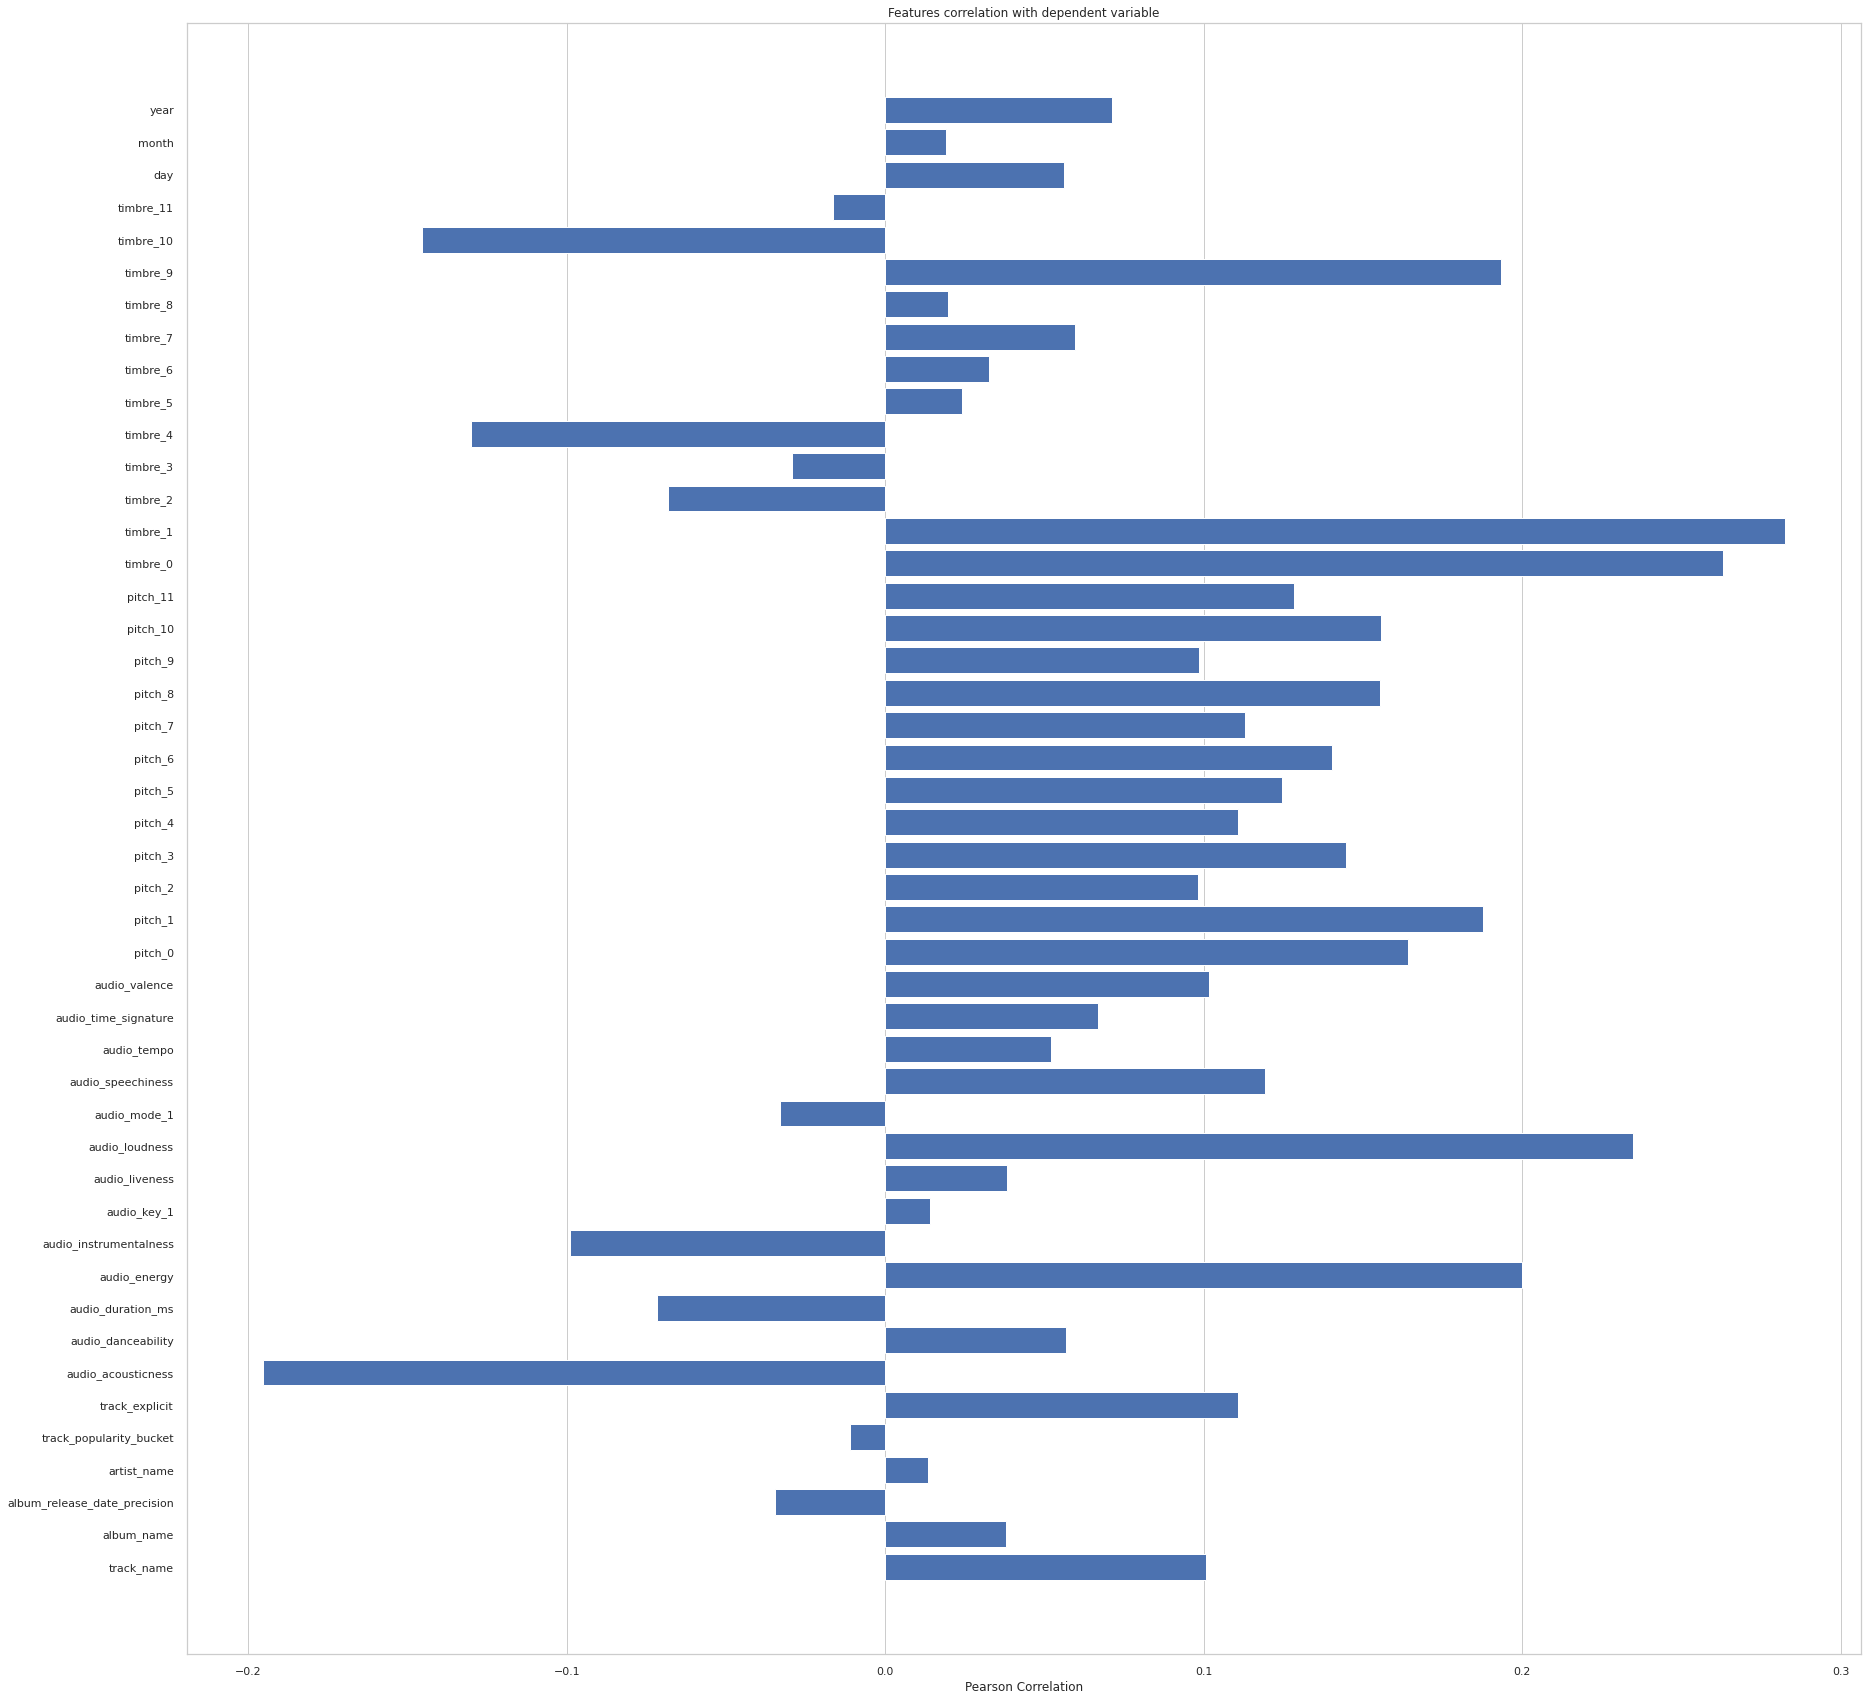

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

feature_names = CATEGORICAL_FEATURES_GENRE + NUMERICAL_FEATURES_GENRE

df = spotify_tracks_genre.toPandas()

ord_enc = OrdinalEncoder()

for col in CATEGORICAL_FEATURES_GENRE:
  df[col] = ord_enc.fit_transform(df[[col]])

df[TARGET_VARIABLE_GENRE] = ord_enc.fit_transform(df[[TARGET_VARIABLE_GENRE]])

X, y = df[feature_names], df[TARGET_VARIABLE_GENRE]

# Create a list of the feature names
features = np.array(feature_names)

# Instantiate the visualizer
visualizer = FeatureCorrelation(labels=features)

plt.rcParams['figure.figsize']=(30,30)
visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show() 

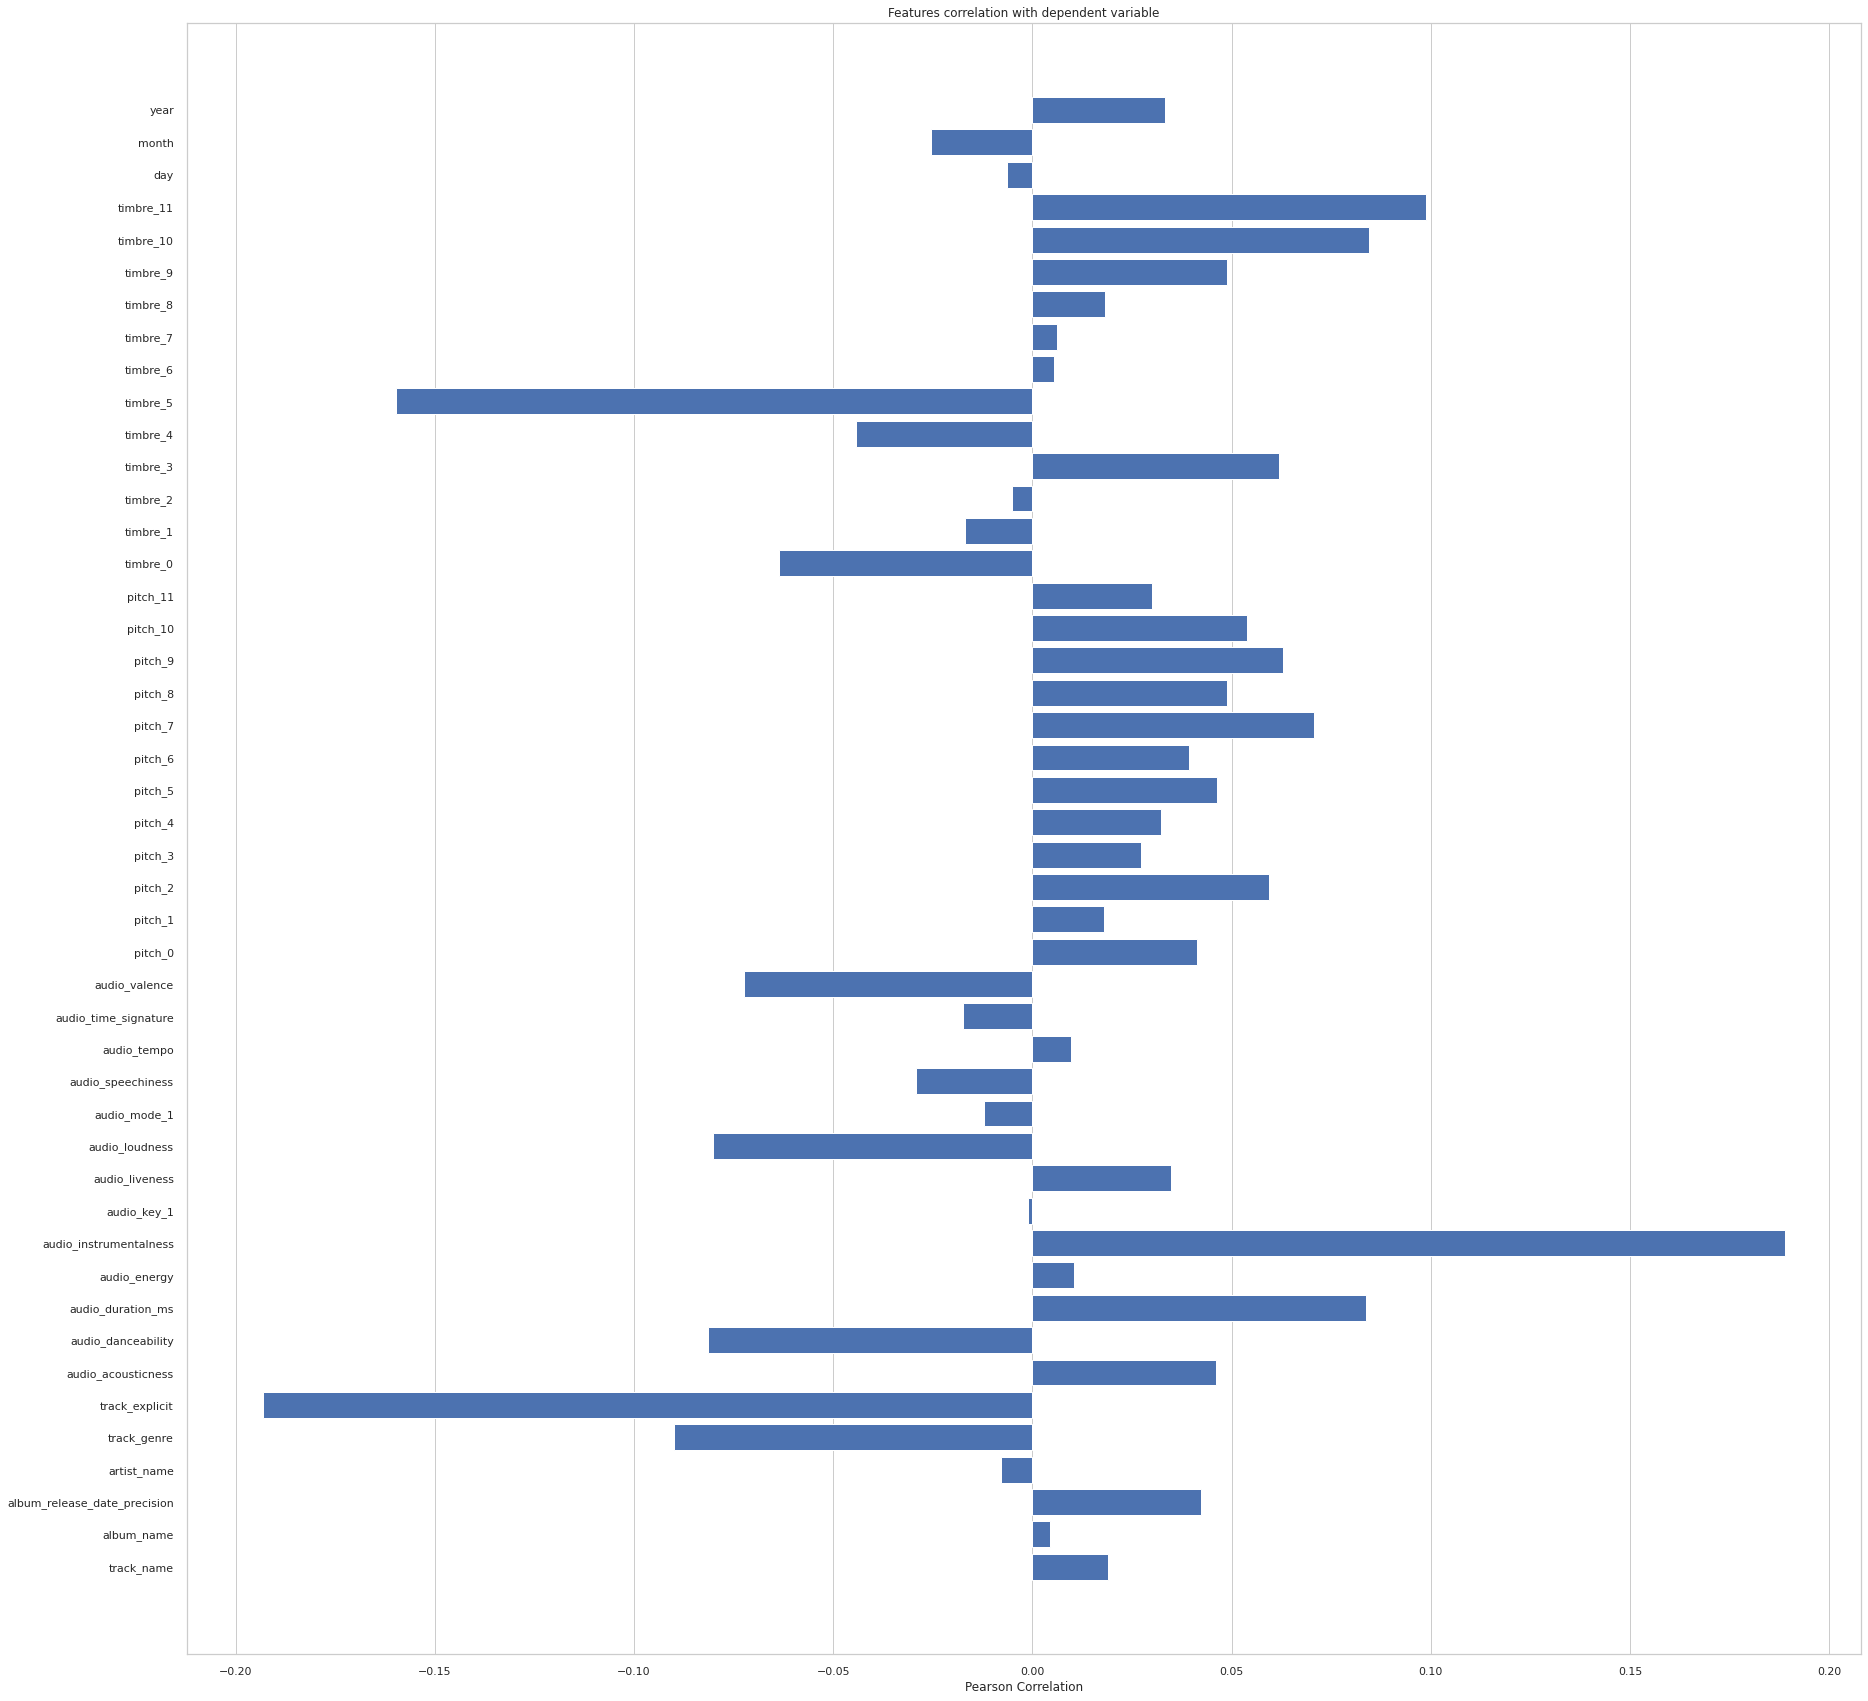

In [ ]:
# FEATURE SELECTION FOR POPULARITY
from sklearn.preprocessing import OrdinalEncoder

feature_names = CATEGORICAL_FEATURES_POPULARITY + NUMERICAL_FEATURES_POPULARITY

df = spotify_tracks_popularity.toPandas()

ord_enc = OrdinalEncoder()

for col in CATEGORICAL_FEATURES_POPULARITY:
  df[col] = ord_enc.fit_transform(df[[col]])

df[TARGET_VARIABLE_POPULARITY] = ord_enc.fit_transform(df[[TARGET_VARIABLE_POPULARITY]])

X, y = df[feature_names], df[TARGET_VARIABLE_POPULARITY]

# Create a list of the feature names

features = np.array(feature_names)

# Instantiate the visualizer
visualizer = FeatureCorrelation(labels=features)

plt.rcParams['figure.figsize']=(30,30)
visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show() 

In [ ]:
del df

## Transform Categorical features into Numerical using One-Hot Encoding

Note that this step is not always mandatory (e.g., decision trees are able to work nicely with categorical features without the need of transforming them to numerical). Still, other methods (like logistic regression) are designed to operate with numerical inputs only.

To transform _categorical_ features into _numerical_ ones we proceed as follows.
We setup a pipeline which is composed of the following steps:
- [`StringIndexer`](https://spark.apache.org/docs/latest/ml-features#stringindexer): encodes a string column of labels to a column of label indices. The indices are in `[0, numLabels)`, and 4 ordering options are supported (default `frequencyDesc`, which assigns the most frequent label the index `0`, and so on and so forth).
- [`OneHotEncoderEstimator`](https://spark.apache.org/docs/latest/ml-features#onehotencoderestimator): maps a categorical feature, represented as a label index, to a binary vector with at most a single one-value indicating the presence of a specific feature value from among the set of all feature values. An important parameter is `handleInvalid`, which indicates how to deal with previously unseen labels. By default this raises an error but it can be set to as `keep` to assign previously unseen labels a fallback value.
- [`VectorAssembler`](https://spark.apache.org/docs/latest/ml-features#vectorassembler): is a transformer that combines a given list of columns into a single vector column.

In [ ]:
# This function is responsible to implement the pipeline above for transforming categorical features into numerical ones
def to_numerical(df, numerical_features, categorical_features, target_variable=""):
  
    # 1. Label Encode target feature
    # In this case our target is the popularity of the tracks that is just
    # numeric in our dataframe, so there is no need to encode it 
    if target_variable != "":
      label_indexer = StringIndexer(inputCol=target_variable, outputCol='label')

    # 2. Label Encode Categorical features
    indexer = [StringIndexer(inputCol=c, outputCol="{0}_index".format(c), handleInvalid="skip") for c in categorical_features]

    # 3. OneHot Encode 
    # stage_3 = OneHotEncoder(inputCol='album_release_date_precision_index', outputCol='album_release_date_precision_oh')

    # 4. create a vector of all the features required to train the logistic regression model 
    assembler = VectorAssembler(inputCols= [i.getOutputCol() for i in indexer] + numerical_features, outputCol='features')

    # 4.a Create the StandardScaler
    scaler = StandardScaler(inputCol=assembler.getOutputCol(), outputCol="s_" + assembler.getOutputCol(), withStd=True, withMean=True)

    normalizer = Normalizer(inputCol=scaler.getOutputCol(), outputCol="std_features") # p=2 default

    # 5. Populate the stages of the pipeline
    if target_variable != "":
      stages = [label_indexer] + indexer + [assembler] + [scaler] + [normalizer]
    else:
      stages = indexer + [assembler] + [scaler] + [normalizer]

    # 6. Setup the pipeline with the stages above
    pipeline = Pipeline(stages=stages)

    # 7. Transform the input dataframe accordingly
    transformer = pipeline.fit(df)
    df_transformed = transformer.transform(df)

    return df_transformed

# **Split the Dataset into train and test set**
## **Dataset Splitting: Training vs. Test Set**

Before moving along with any preprocessing involving data transformations, we will split our dataset into **2** portions:
- _training set_ (e.g., accounting for **80%** of the total number of instances);
- _test set_ (e.g., accounting for the remaining **20%** of instances)

In [ ]:
# GENRE DATASET

# Transform the training set and get back both the transformer and the new dataset
spotify_tracks_genre = to_numerical(spotify_tracks_genre, NUMERICAL_FEATURES_GENRE, CATEGORICAL_FEATURES_GENRE, TARGET_VARIABLE_GENRE)
spotify_tracks_genre.cache()

# Select `features` and `label` (i.e., formerly `deposit`) target variable only
spotify_tracks_genre = spotify_tracks_genre.select(["std_features", "label"])
spotify_tracks_genre.cache()

RANDOM_SEED = 42
# Randomly split our original dataset `house_df` into 80÷20 for training and test, respectively
train_set_genre, test_set_genre = spotify_tracks_genre.randomSplit([0.8, 0.2], seed=RANDOM_SEED)

train_set_genre.show()

+--------------------+-----+
|        std_features|label|
+--------------------+-----+
|[-0.3458463044655...|  5.0|
|[-0.3426956835909...|  6.0|
|[-0.2470280208511...|  1.0|
|[-0.2420448616192...| 10.0|
|[-0.2334403862836...|  7.0|
|[-0.2137183676452...|  9.0|
|[-0.1920833055058...|  9.0|
|[-0.1814832160765...| 10.0|
|[-0.1811264691215...| 10.0|
|[-0.1735055610150...|  9.0|
|[-0.1467010914870...|  1.0|
|[-0.1445124307344...|  3.0|
|[-0.1341949444186...| 10.0|
|[-0.1248050649868...|  5.0|
|[-0.1203021135098...|  7.0|
|[-0.1016314190606...|  8.0|
|[-0.0926196795706...|  7.0|
|[-0.0871141620212...|  8.0|
|[-0.0257448652055...|  8.0|
|[-0.0138114572068...|  1.0|
+--------------------+-----+
only showing top 20 rows



In [ ]:
train_set_genre.cache()

DataFrame[std_features: vector, label: double]

In [ ]:
# POPULARITY DATASET

# Transform the training set and get back both the transformer and the new dataset
spotify_tracks_popularity = to_numerical(spotify_tracks_popularity, NUMERICAL_FEATURES_POPULARITY, CATEGORICAL_FEATURES_POPULARITY, TARGET_VARIABLE_POPULARITY)
spotify_tracks_popularity.cache()

# Select `features` and `label` (i.e., formerly `deposit`) target variable only
spotify_tracks_popularity = spotify_tracks_popularity.select(["std_features", "label"])
spotify_tracks_popularity.cache()

RANDOM_SEED = 42
# Randomly split our original dataset `house_df` into 80÷20 for training and test, respectively
train_set_popularity, test_set_popularity = spotify_tracks_popularity.randomSplit([0.8, 0.2], seed=RANDOM_SEED)

train_set_popularity.show()

+--------------------+-----+
|        std_features|label|
+--------------------+-----+
|[-0.2848163170895...|  2.0|
|[-0.2610127689661...|  2.0|
|[-0.2032105410114...|  1.0|
|[-0.1956984627558...|  2.0|
|[-0.1848907125896...|  2.0|
|[-0.1762370176854...|  0.0|
|[-0.1712150410939...|  1.0|
|[-0.1578757602152...|  3.0|
|[-0.1539716564570...|  0.0|
|[-0.1490490951044...|  0.0|
|[-0.1442459279200...|  0.0|
|[-0.1023093781403...|  1.0|
|[-0.0985627167155...|  3.0|
|[-0.0938759466045...|  3.0|
|[-0.0803888983242...|  3.0|
|[-0.0686998513971...|  2.0|
|[-0.0595003308178...|  3.0|
|[-0.0536770811458...|  2.0|
|[-0.0414261247838...|  1.0|
|[-0.0257383190342...|  2.0|
+--------------------+-----+
only showing top 20 rows



In [ ]:
train_set_popularity.cache()

DataFrame[std_features: vector, label: double]

# Training and Evaluation

## Function for Evaluation

In [ ]:
def evaluate(cv_model, test_prediction):

  for i, avg_roc_auc in enumerate(cv_model.avgMetrics):
      print("Avg. ROC AUC computed across k-fold cross validation for model setting #{:d}: {:.3f}".format(i+1, avg_roc_auc))

  print(cv_model.bestModel.stages[-1])

  print("##### Test Set #####")
  evaluator = cv_model.getEvaluator()
  print('Test F1-Score ',   evaluator.evaluate(test_prediction, {evaluator.metricName: 'f1'}))
  print('Test Precision ',  evaluator.evaluate(test_prediction, {evaluator.metricName: 'weightedPrecision'}))
  print('Test Recall ',     evaluator.evaluate(test_prediction, {evaluator.metricName: 'weightedRecall'}))
  print('Test Accuracy ',   evaluator.evaluate(test_prediction, {evaluator.metricName: 'accuracy'}))
  print("####################")

  # Questa poi la useremo per fare i plot di confronto tra i vari modelli
  evaluation_list = [evaluator.evaluate(test_prediction, {evaluator.metricName: 'f1'}),
                     evaluator.evaluate(test_prediction, {evaluator.metricName: 'weightedPrecision'}),
                     evaluator.evaluate(test_prediction, {evaluator.metricName: 'weightedRecall'}),
                     evaluator.evaluate(test_prediction, {evaluator.metricName: 'accuracy'})]

  return evaluation_list

## Decision Tree

Decision Tree is a supervised machine learning algorithm that creates a tree with three important components:
- Test node: that is a test on a specific feature;
- Leaf node: that represents a decision (classification);
- Edge: that can link two test nodes or one test node to a leaf node.
A decision tree can be re-written as a set of rules and the "function" to minimize is the depth of the tree, but is a NP-Hard problem and so a Greedy technique is even good. One possibility is to define "the order" of testing the different features, based for example on the information gain that is based on the entropy that represents the "disorder" of the set (of instances) that we are using.

In [ ]:
# This function defines the general pipeline for logistic regression
def decision_tree_pipeline(train):
  
  stage_5_dr = DecisionTreeClassifier(featuresCol='std_features',labelCol='label')

  decision_tree_pipeline = Pipeline(stages= [stage_5_dr])

  #### DECISION TREE
  param_grid = ParamGridBuilder()\
    .addGrid(stage_5_dr.maxDepth, [3, 5, 8]) \
    .addGrid(stage_5_dr.impurity, ["gini", "entropy"]) \
    .build()
  cross_val_dt = CrossValidator(estimator=decision_tree_pipeline,
                                estimatorParamMaps=param_grid,
                                evaluator=MulticlassClassificationEvaluator(),
                                numFolds=5,
                                collectSubModels=True
                                )
  train.cache()
  cv_model_dt = cross_val_dt.fit(train)

  return cv_model_dt

In [ ]:
cv_model_genre_dt = decision_tree_pipeline(train_set_genre)

test_predictions_genre_dt = cv_model_genre_dt.transform(test_set_genre)

test_predictions_genre_dt.select("std_features", "prediction", "label").show(5)

+--------------------+----------+-----+
|        std_features|prediction|label|
+--------------------+----------+-----+
|[-0.2682238100391...|       9.0|  5.0|
|[-0.2224999396646...|       8.0|  5.0|
|[-0.1968418286441...|       9.0|  9.0|
|[-0.1562360607789...|       2.0|  2.0|
|[-0.1096963843312...|      10.0|  8.0|
+--------------------+----------+-----+
only showing top 5 rows



In [ ]:
cv_model_popularity_dt = decision_tree_pipeline(train_set_popularity)

test_predictions_popularity_dt = cv_model_popularity_dt.transform(test_set_popularity)

test_predictions_popularity_dt.select("std_features", "prediction", "label").show(5)

+--------------------+----------+-----+
|        std_features|prediction|label|
+--------------------+----------+-----+
|[-0.2239800902532...|       0.0|  0.0|
|[-0.1827751885447...|       1.0|  1.0|
|[-0.1712827706429...|       0.0|  3.0|
|[-0.1443127886323...|       2.0|  1.0|
|[-0.0724043771272...|       2.0|  1.0|
+--------------------+----------+-----+
only showing top 5 rows



### Evaluation

In [ ]:
print("Best model according to k-fold cross validation: maxDept=[{:d}]".
      format(cv_model_genre_dt.bestModel.stages[-1]._java_obj.getMaxDepth()
             )
      )
el_genre_dt = evaluate(cv_model_genre_dt, test_predictions_genre_dt)

Best model according to k-fold cross validation: maxDept=[8]
Avg. ROC AUC computed across k-fold cross validation for model setting #1: 0.241
Avg. ROC AUC computed across k-fold cross validation for model setting #2: 0.231
Avg. ROC AUC computed across k-fold cross validation for model setting #3: 0.353
Avg. ROC AUC computed across k-fold cross validation for model setting #4: 0.335
Avg. ROC AUC computed across k-fold cross validation for model setting #5: 0.400
Avg. ROC AUC computed across k-fold cross validation for model setting #6: 0.395
DecisionTreeClassificationModel: uid=DecisionTreeClassifier_04ec15928a37, depth=8, numNodes=429, numClasses=11, numFeatures=46
##### Test Set #####
Test F1-Score  0.39811278963566293
Test Precision  0.42264951311830146
Test Recall  0.40415276232851316
Test Accuracy  0.40415276232851316
####################


In [ ]:
print("Best model according to k-fold cross validation: maxDept=[{:d}]".
      format(cv_model_popularity_dt.bestModel.stages[-1]._java_obj.getMaxDepth()
             )
      )
el_popularity_dt = evaluate(cv_model_popularity_dt, test_predictions_popularity_dt)

Best model according to k-fold cross validation: maxDept=[8]
Avg. ROC AUC computed across k-fold cross validation for model setting #1: 0.372
Avg. ROC AUC computed across k-fold cross validation for model setting #2: 0.346
Avg. ROC AUC computed across k-fold cross validation for model setting #3: 0.392
Avg. ROC AUC computed across k-fold cross validation for model setting #4: 0.380
Avg. ROC AUC computed across k-fold cross validation for model setting #5: 0.411
Avg. ROC AUC computed across k-fold cross validation for model setting #6: 0.400
DecisionTreeClassificationModel: uid=DecisionTreeClassifier_a622fd708583, depth=8, numNodes=387, numClasses=4, numFeatures=46
##### Test Set #####
Test F1-Score  0.40950494843510343
Test Precision  0.4118899145996873
Test Recall  0.42324827865532605
Test Accuracy  0.42324827865532605
####################


In [ ]:
# Let's try to free-up some RAM
import gc

del test_predictions_genre_dt, test_predictions_popularity_dt, train_set_popularity, train_set_genre, test_set_genre, test_set_popularity

print("Garbage collector: collected %d objects" % (gc.collect()))

Garbage collector: collected 0 objects


## **Logistic Regression**

We first train a logistic regression model, using the training set above. To do so, we use the `LogisticRegression` object provided by the [PySpark API](https://spark.apache.org/docs/latest/ml-classification-regression.html#logistic-regression) within the package `pyspark.ml.classification`.

The API is similar to the one we have seen for Linear Regression (i.e., implementing the **Elastic Net** regularization framework), except for the loss function which now is **cross-entropy** rather than **mean squared error**:
$$
\boldsymbol{\theta}^* = \text{argmin}_{\boldsymbol{\theta}\in \mathbb{R}^n} \frac{1}{m} \sum_{i=1}^m \log_e(1 + e^{-y_i\boldsymbol{\theta}^T\mathbf{x}_i}) + \lambda\Big(\alpha |\boldsymbol{\theta}| + (1-\alpha)||\boldsymbol{\theta}||^2\Big)
$$
In particular, we can specify the following parameters:

- `regParam` is the regularization parameter (or $\lambda$);
- `elasticNetParam` is the tradeoff parameter for regularization penalties (or $\alpha$);
  - `regParam = 0` and `elasticNetParam = 0` means there is no regularization;
  - `regParam > 0` and `elasticNetParam = 0` means there is only L2-regularization; 
  - `regParam > 0` and `elasticNetParam = 1` means there is only L1-regularization;
  - `regParam > 0` and `0 < elasticNetParam < 1` means there is both L1- and L2-regularization (Elastic Net);

As it is always the case, the optimal values of those **hyperparameters** should be tuned using a dedicated portion of the dataset (i.e., **validation set**) or by performing $k$**-fold cross validation**.

In [ ]:
# This function defines the general pipeline for logistic regression
def logistic_regression_pipeline(train):
  
    stage_5_lg = LogisticRegression(featuresCol='std_features',labelCol='label')

    logistic_regression_pipeline = Pipeline(stages= [stage_5_lg])

    #### LOGISTIC REGRESSION
    param_grid = ParamGridBuilder()\
    .addGrid(stage_5_lg.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(stage_5_lg.maxIter, [10, 20, 50]) \
    .build()
    # other param: .addGrid(stage_4_lg.elasticNetParam, [0.0, 0.25, 0.5, 0.75, 1.0])
    cross_val_lg = CrossValidator(estimator=logistic_regression_pipeline,
                            estimatorParamMaps=param_grid,
                            evaluator=MulticlassClassificationEvaluator(), 
                            numFolds=5,
                            collectSubModels=True
                            )
    train.cache()
    cv_model_lg = cross_val_lg.fit(train)

    return cv_model_lg

In [ ]:
cv_model_genre_lg = logistic_regression_pipeline(train_set_genre)

test_predictions_genre_lg = cv_model_genre_lg.transform(test_set_genre)

test_predictions_genre_lg.select("std_features", "prediction", "label").show(5)

In [ ]:
cv_model_popularity_lg = logistic_regression_pipeline(train_set_popularity)

test_predictions_popularity_lg = cv_model_popularity_lg.transform(test_set_popularity)

test_predictions_popularity_lg.select("std_features", "prediction", "label").show(5)

+--------------------+----------+-----+
|        std_features|prediction|label|
+--------------------+----------+-----+
|[-1.5300269238464...|       0.0|  2.0|
|[-1.4664837755759...|       0.0|  2.0|
|[-1.3951774372453...|       3.0|  3.0|
|[-0.9391619025983...|       0.0|  0.0|
|[-0.4676199878310...|       3.0|  2.0|
+--------------------+----------+-----+
only showing top 5 rows



### Evaluation

In [ ]:
print("Best model according to k-fold cross validation: lambda=[{:.3f}]; alfa=[{:.3f}]".
      format(cv_model_genre_lg.bestModel.stages[-1]._java_obj.getRegParam(),
             cv_model_genre_lg.bestModel.stages[-1]._java_obj.getElasticNetParam()
             )
      )

el_genre_lg = evaluate(cv_model_genre_lg, test_predictions_genre_lg)

In [ ]:
print("Best model according to k-fold cross validation: lambda=[{:.3f}]; alfa=[{:.3f}]".
      format(cv_model_popularity_lg.bestModel.stages[-1]._java_obj.getRegParam(),
             cv_model_popularity_lg.bestModel.stages[-1]._java_obj.getElasticNetParam()
             )
      )

el_popularity_lg = evaluate(cv_model_popularity_lg, test_predictions_popularity_lg)

## Random Forest

The ensamble method is a supervised machine learning algorithm that is represented by a set of classifiers that learn a target function and combine the prediction of the single classifier to predict unseen instances. This algorithm reduces the variance and improves the generalization and the Random Forest algorithm is one of the techniques to manipulate the Data set. In particular, it uses a set of decision trees, learned with the random vector method, and then combines the prediction with one of the two voting methods.

In [ ]:
# This function defines the general pipeline for logistic regression
def random_forest_pipeline(train):
  
  stage_5_rf = RandomForestClassifier(featuresCol="std_features", labelCol="label")

  random_forest_pipeline = Pipeline(stages= [stage_5_rf])

  #### RANDOM FOREST
  param_grid = ParamGridBuilder()\
    .addGrid(stage_5_rf.maxDepth, [3, 5, 8]) \
    .addGrid(stage_5_rf.numTrees, [10, 50, 100]) \
    .build()

  cross_val_rf = CrossValidator(estimator=random_forest_pipeline, 
                              estimatorParamMaps=param_grid,
                              evaluator= MulticlassClassificationEvaluator(),
                              numFolds=5,
                              collectSubModels=True 
                              )
  train.cache()
  cv_model_rf = cross_val_rf.fit(train)

  return cv_model_rf

In [ ]:
cv_model_genre_rf = random_forest_pipeline(train_set_genre)

test_predictions_genre_rf = cv_model_genre_rf.transform(test_set_genre)

test_predictions_genre_rf.select("std_features", "prediction", "label").show(5)

In [ ]:
cv_model_popularity_rf = random_forest_pipeline(train_set_popularity)

test_predictions_popularity_rf = cv_model_popularity_rf.transform(test_set_popularity)

test_predictions_popularity_rf.select("std_features", "prediction", "label").show(5)

### Evaluation

In [ ]:
print("Best model according to k-fold cross validation: maxDept=[{:d}]".
      format(cv_model_genre_rf.bestModel.stages[-1]._java_obj.getMaxDepth()
             )
      )
el_genre_rf = evaluate(cv_model_genre_rf, test_predictions_genre_rf)

In [ ]:
print("Best model according to k-fold cross validation: maxDept=[{:d}]".
      format(cv_model_popularity_rf.bestModel.stages[-1]._java_obj.getMaxDepth()
             )
      )
el_popularity_rf = evaluate(cv_model_popularity_rf, test_predictions_popularity_rf)

## Multi Layer Perceptron

MLPNs is a supervised machine learning algorithm and it made use of perceptrons. The structure of MLPNs is composed of input, hidden and output layers fully connected one to the other with a feed-forward activation function. It made use of a Convolutional function to "active" or not one node (perceptron). In MLPNs we want that our outputs are closer as possible to the right one, and so we have to iteratively adjust the weights of each edge.

In [ ]:
# This function defines the general pipeline for logistic regression
def multi_layer_perceptron_pipeline(train):
  
  stage_5_mlp = MultilayerPerceptronClassifier(featuresCol="std_features", labelCol="label")

  multi_layer_perceptron_pipeline = Pipeline(stages= [stage_5_mlp])

  #### MULTI LAYER PERCEPTRON
  param_grid = ParamGridBuilder()\
    .addGrid(stage_5_mlp.layers, [[4,5,3], [4,5,5,3], [4,10,7,5]]) \
    .addGrid(stage_5_mlp.seed, [0, 123]) \
    .build()

  cross_val_mlp = CrossValidator(estimator=multi_layer_perceptron_pipeline, 
                              estimatorParamMaps=param_grid,
                              evaluator= MulticlassClassificationEvaluator(),
                              numFolds=5,
                              collectSubModels=True 
                              )
  train.cache()
  cv_model_mlp = cross_val_mlp.fit(train)

  return cv_model_mlp

In [ ]:
cv_model_genre_mlp = multi_layer_perceptron_pipeline(train_set_genre)

test_predictions_genre_mlp = cv_model_genre_mlp.transform(test_set_genre)

test_predictions_genre_mlp.select("std_features", "prediction", "label").show(5)

In [ ]:
cv_model_popularity_mlp = multi_layer_perceptron_pipeline(train_set_popularity)

test_predictions_popularity_mlp = cv_model_popularity_mlp.transform(test_set_popularity)

test_predictions_popularity_mlp.select("std_features", "prediction", "label").show(5)

### Evaluation

In [ ]:
print("Best model according to k-fold cross validation: ", cv_model_genre_mlp.bestModel.stages[-1]._java_obj.getLayers())
el_genre_mlp = evaluate(cv_model_genre_mlp, test_predictions_genre_mlp)

In [ ]:
print("Best model according to k-fold cross validation: ", cv_model_popularity_mlp.bestModel.stages[-1]._java_obj.getLayers())
el_popularity_mlp = evaluate(cv_model_popularity_mlp, test_predictions_popularity_mlp)

## K-means Clustering

In [ ]:
# We define some parameters for K-means clustering

N_CLUSTERS = 12 # number of output clusters (K)
DISTANCE_MEASURE = "euclidean" # alternatively, "cosine"
MAX_ITERATIONS = 100 # maximum number of iterations of K-means EM algorithm
TOLERANCE = 0.000001 # tolerance between consecutive centroid updates (i.e., another stopping criterion)

In [ ]:
# We define a function used for running k-means

def k_means(dataset=spotify_tracks_genre, 
            n_clusters, 
            distance_measure=DISTANCE_MEASURE, 
            max_iter=MAX_ITERATIONS, 
            tol=TOLERANCE,
            features_col="features", 
            prediction_col="cluster", 
            random_seed=RANDOM_SEED):

  print("""Training K-means clustering using the following parameters: 
  - K (n. of clusters) = {:d}
  - max_iter (max n. of iterations) = {:d}
  - distance measure = {:s}
  - random seed = {:d}
  """.format(n_clusters, max_iter, distance_measure, random_seed))
  # Train a K-means model
  kmeans = KMeans(featuresCol=features_col, 
                   predictionCol=prediction_col, 
                   k=n_clusters, 
                   initMode="k-means||", 
                   initSteps=5, 
                   tol=tol, 
                   maxIter=max_iter, 
                   seed=random_seed, 
                   distanceMeasure=distance_measure)
  model = kmeans.fit(dataset)

  # Make clusters
  clusters_df = model.transform(dataset).cache()

  return model, clusters_df

In [ ]:
# Run K-means by calling the function 

model, clusters_df = k_means(features, N_CLUSTERS, max_iter=MAX_ITERATIONS, distance_measure=DISTANCE_MEASURE)

### Evaluate obtained clusters

To evaluate the clusters obtained we use the Silhouette Coefficient, which is a measure for the validation of the consistency within clusters. It ranges between 1 and -1, where a value close to 1 means that the points in a cluster are close to the other points in the same cluster and far from the points of the other clusters.

In [ ]:
# Here we define a function used to evaluate obtained clusters (Silhouette Coefficient)

def evaluate_k_means(clusters, 
                     metric_name="silhouette", 
                     distance_measure="squaredEuclidean", # cosine
                     prediction_col="cluster"
                     ):
  
  # Evaluate clustering by computing Silhouette score
  evaluator = ClusteringEvaluator(metricName=metric_name,
                                  distanceMeasure=distance_measure, 
                                  predictionCol=prediction_col
                                  )

  return evaluator.evaluate(clusters)

In [ ]:
# We can evaluate the clustering we just run using K = 10 clusters

evaluate_k_means(clusters_df, distance_measure="squareEuclidian")
clusters_df.show(5)

In [ ]:
clusters_df.groupBy("cluster").count().sort("cluster").show()

In [ ]:
# Get unique values in the grouping column
clusters = sorted([x[0] for x in clusters_df.select("cluster").distinct().collect()])
print("Cluster IDs: [{:s}]".format(", ".join([str(c) for c in clusters])))

# Create a filtered DataFrame for each group in a list comprehension
cluster_list = [clusters_df.where(clusters_df.cluster == x) for x in clusters]

# Show the results (first 5 cluters)
for x_id, x in enumerate(cluster_list):
  print("Showing the first 10 records of cluster ID #{:d}".format(x_id))
  x.select(["cluster", "track_genre"]).show(10, truncate=True)

## Model Comparison

In [ ]:
def plot(total_list)
  # List of required attributes
  attributes = ["Decision Tree", "Logistic Regression", "Random Forest", "Multi Layer Perceptron"]

  # Arrays used to store the total number of Boolean values for each feature
  total_f1 = total_list[0, 4, 8, 12]
  total_wP = total_list[1, 5, 9, 13]
  total_wR = total_list[2, 6, 10, 14]
  total_ac = total_list[3, 7, 11, 15]

  # Declaring the figure or the plot (y, x) or (width, height)
  plt.figure(figsize=[20, 10])

  # Using numpy to group different data with bars
  number_list = np.arange(len(total_zero))

  for attribute in attributes:
      plt.bar(number_list, total_f1, color = 'orange', width = 0.35)
      plt.bar(number_list + 0.35, total_wP, color = 'blue', width = 0.35)
      plt.bar(number_list, total_wR, color = 'red', width = 0.35)
      plt.bar(number_list + 0.35, total_ac, color = 'green', width = 0.35)
      
  # Creating the legend of the bars in the plot
  plt.legend(['f1', 'weightedPrecision', 'weightedRecall', 'accuracy'])

  # Overiding the x axis with the feature names
  plt.xticks([i + 0.35 for i in range(len(attributes))], attributes)

  # Giving the tilte for the plot
  plt.title("Model Comparison")

  # Namimg the x and y axis
  plt.xlabel('Model')
  plt.ylabel('Tot')

  # Displaying the bar plot
  plt.show()

In [ ]:
total_genre_list = el_genre_dt + el_genre_lg + el_genre_dt + el_genre_mlp
plot(total_genre_list)

total_popularity_list = el_popularity_dt + el_popularity_lg + el_popularity_rf + el_popularity_mlp
plot(total_popularity_list)

# Content-based Recommender

In [ ]:
# Testo da "riscirvere"

A content-based recommender leverages attributes from items the user has interacted with to recommend similar items. As it depends only on the past this method avoids the cold-start problem for implementation.

For text items we can use a popular information retrieval method used in search engines named TF-IDF. This technique converts unstructured text into a vector structure, where each word is represented by a position in the vector, and the value measures how relevant a given word is for an article. We can then compute the cosine similarity between the user vector and the initial sparse matrix (all users).

Content-based Filtering Recommendation
The next step is to perform content-based filtering based on the song features we have. To do so, we concatenate all songs in a playlist into one summarization vector. Then, we find the similarity between the summarized playlist vector with all songs (not including the songs in the playlist) in the database. Then, we use the similarity measure retrieved the most relevant song that is not in the playlist to recommend it.

There are thre steps in this section:



1.   Choose playlist: In this part, we retrieve a playlist
2.   Extract features: In this part, we retireve playlist-of-interest features and non-playlist-of-interest features.
3. Find similarity: In this part, we compare the summarized playlist features with all other songs.


## Upload playlist Dataset


In [ ]:
PLAYLIST_DATASET_URL = "https://raw.githubusercontent.com/AndreaBe99/big-data-project/main/data/playlist_dataframe.csv"
GDRIVE_PLAYLIST_DATASET_FILE = GDRIVE_DATA_DIR + "/" + PLAYLIST_DATASET_URL.split("/")[-1]

def get_data(dataset_url, dest, chunk_size=1024):
  response = requests.get(dataset_url, stream=True)
  if response.status_code == 200: # Test if everything went ok
    with open(dest, "wb") as file:
      for block in response.iter_content(chunk_size=chunk_size): 
        if block: 
          file.write(block)


print("Retrieving dataset from URL: {} ...".format(PLAYLIST_DATASET_URL))
get_data(PLAYLIST_DATASET_URL, GDRIVE_DATASET_FILE)
print("Dataset successfully retrieved and stored at: {}".format(GDRIVE_PLAYLIST_DATASET_FILE))

Retrieving dataset from URL: https://raw.githubusercontent.com/AndreaBe99/big-data-project/main/data/playlist_dataframe.csv ...
Dataset successfully retrieved and stored at: /content/gdrive/My Drive/Sapienza/Primo Anno/Big Data Computing/Project/playlist_dataframe.csv


In [ ]:
playlist_tracks = spark.read.load(GDRIVE_PLAYLIST_DATASET_FILE, 
                           format="csv", 
                           sep=",", 
                           inferSchema="true", 
                           header="true")

In [ ]:
playlist_tracks.show()

+--------------------+-------------------+--------------------+--------------------+--------------+----------------+--------------------+------------------+----------------------------+--------------------+--------------------+--------------------+------------------+------------------+-----------------+------------+----------------------+-----------+--------------+--------------+------------+-----------------+-----------+--------------------+-------------+--------------------+
|         playlist_id|      playlist_name|            track_id|          track_name|track_explicit|track_popularity|          album_name|album_release_date|album_release_date_precision|         artist_name|   audio_avg_pitches|    audio_avg_timbre|audio_acousticness|audio_danceability|audio_duration_ms|audio_energy|audio_instrumentalness|audio_key_1|audio_liveness|audio_loudness|audio_mode_1|audio_speechiness|audio_tempo|audio_time_signature|audio_valence|           track_uri|
+--------------------+--------------

In [ ]:
playlist_tracks.printSchema()

root
 |-- playlist_id: string (nullable = true)
 |-- playlist_name: string (nullable = true)
 |-- track_id: string (nullable = true)
 |-- track_name: string (nullable = true)
 |-- track_explicit: boolean (nullable = true)
 |-- track_popularity: integer (nullable = true)
 |-- album_name: string (nullable = true)
 |-- album_release_date: string (nullable = true)
 |-- album_release_date_precision: string (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- audio_avg_pitches: string (nullable = true)
 |-- audio_avg_timbre: string (nullable = true)
 |-- audio_acousticness: double (nullable = true)
 |-- audio_danceability: double (nullable = true)
 |-- audio_duration_ms: integer (nullable = true)
 |-- audio_energy: double (nullable = true)
 |-- audio_instrumentalness: double (nullable = true)
 |-- audio_key_1: integer (nullable = true)
 |-- audio_liveness: double (nullable = true)
 |-- audio_loudness: double (nullable = true)
 |-- audio_mode_1: integer (nullable = true)
 |-- aud

In [ ]:
print("The shape of the dataset is {:d} rows by {:d} columns".format(playlist_tracks.count(), len(playlist_tracks.columns)))

The shape of the dataset is 130 rows by 26 columns


In [ ]:
playlist_name = "😝Finto Alternativo"

In [ ]:
# Select the playlist where we want add new songs
one_playlist_tracks = playlist_tracks.where(playlist_tracks.playlist_name == playlist_name)

In [ ]:
print("The shape of the dataset is {:d} rows by {:d} columns".format(one_playlist_tracks.count(), len(one_playlist_tracks.columns)))

The shape of the dataset is 100 rows by 26 columns


In [ ]:
one_playlist_tracks_splitted = split_array_columns(one_playlist_tracks, "audio_avg_pitches", "pitch_")
one_playlist_tracks_splitted = split_array_columns(one_playlist_tracks_splitted, "audio_avg_timbre", "timbre_")
del one_playlist_tracks

one_playlist_tracks = split_date(one_playlist_tracks_splitted, "album_release_date")
del one_playlist_tracks_splitted

In [ ]:
# Delete columns
cols = ("playlist_id", "playlist_name", "track_uri")
one_playlist_tracks = one_playlist_tracks.drop(*cols)

In [ ]:
one_playlist_tracks.printSchema()

root
 |-- track_id: string (nullable = true)
 |-- track_name: string (nullable = true)
 |-- track_explicit: boolean (nullable = true)
 |-- track_popularity: integer (nullable = true)
 |-- album_name: string (nullable = true)
 |-- album_release_date_precision: string (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- audio_acousticness: double (nullable = true)
 |-- audio_danceability: double (nullable = true)
 |-- audio_duration_ms: integer (nullable = true)
 |-- audio_energy: double (nullable = true)
 |-- audio_instrumentalness: double (nullable = true)
 |-- audio_key_1: integer (nullable = true)
 |-- audio_liveness: double (nullable = true)
 |-- audio_loudness: double (nullable = true)
 |-- audio_mode_1: integer (nullable = true)
 |-- audio_speechiness: double (nullable = true)
 |-- audio_tempo: double (nullable = true)
 |-- audio_time_signature: integer (nullable = true)
 |-- audio_valence: double (nullable = true)
 |-- pitch_0: double (nullable = true)
 |-- pitch_1: 

In [ ]:
# Save two datset to csv 
playlist = one_playlist_tracks.toPandas()
playlist.to_csv("pandas_playlist.csv")


## Clean and organize the two dataset


In [ ]:
# upload dataset
playlist= spark.read.load("pandas_playlist.csv", format="csv", sep=",", inferSchema="true",header="true") 
all_tracks = spark.read.load("full_pandas_all_tracks.csv", format="csv", sep=",", inferSchema="true",header="true") # Full
all_tracks = all_tracks.withColumnRenamed("id","track_id")

all_tracks_original = all_tracks.alias('all_tracks_original')
all_tracks_original = all_tracks_original.withColumnRenamed("id","track_id")

In [ ]:
print("The shape of the 'all_tracks' dataset is {:d} rows by {:d} columns".format(all_tracks.count(), len(all_tracks.columns)))

print("The shape of the 'playlist' dataset is {:d} rows by {:d} columns".format(playlist.count(), len(playlist.columns)))

The shape of the 'all_tracks' dataset is 68260 rows by 49 columns
The shape of the 'playlist' dataset is 100 rows by 48 columns


In [ ]:
# Drop album_release_date_precision because is redundant
playlist = playlist.drop("album_release_date_precision")
all_tracks = all_tracks.drop("album_release_date_precision")
# Drop also genre from all_tracks
all_tracks = all_tracks.drop("track_genre")

## Preprocessing the two dataset 

In [ ]:
playlist_cat = [item[0] for item in playlist.dtypes if item[1].startswith('string')]
all_tracks_cat = [item[0] for item in all_tracks.dtypes if item[1].startswith('string')]

print(playlist_cat)
print(all_tracks_cat)

['track_id', 'track_name', 'album_name', 'artist_name']
['track_id', 'track_name', 'track_explicit', 'track_popularity', 'album_name', 'artist_name', 'audio_acousticness', 'audio_danceability', 'audio_duration_ms', 'audio_energy', 'audio_instrumentalness', 'audio_key_1', 'audio_liveness', 'audio_loudness', 'audio_mode_1', 'audio_speechiness', 'audio_tempo', 'pitch_0', 'pitch_1', 'pitch_2', 'pitch_3', 'pitch_4', 'pitch_5', 'pitch_6', 'pitch_7', 'pitch_8', 'pitch_9', 'pitch_10']


In [ ]:
# Cast to correct value
for col in playlist.dtypes:
  col_type = col[1]
  if col_type != all_tracks.schema[col[0]].dataType:
    all_tracks = all_tracks.withColumn(col[0], all_tracks[col[0]].cast(col[1]))


In [ ]:
playlist_cat = [item[0] for item in playlist.dtypes if item[1].startswith('string')]
all_tracks_cat = [item[0] for item in all_tracks.dtypes if item[1].startswith('string')]

# We do not want the encoding of id beacause we need it later
playlist_cat.remove("track_id")
all_tracks_cat.remove("track_id")

print(playlist_cat)
print(all_tracks_cat)

['track_name', 'album_name', 'artist_name']
['track_name', 'album_name', 'artist_name']


In [ ]:
# Cast Bool to Int
playlist = playlist.withColumn("track_explicit", playlist["track_explicit"].cast("int"))
all_tracks = all_tracks.withColumn("track_explicit", all_tracks["track_explicit"].cast("int"))

In [ ]:
# Drop null
all_tracks = all_tracks.dropna()

In [ ]:
# Let's define some constants which we will use throughout this notebook
NUMERICAL_FEATURES = []
CATEGORICAL_FEATURES = []

#Get All column names and it's types
for col in playlist.dtypes:
    if col[1] == "string":
        CATEGORICAL_FEATURES.append(col[0])
    else:
        NUMERICAL_FEATURES.append(col[0])

CATEGORICAL_FEATURES.remove("track_id")
NUMERICAL_FEATURES.remove("_c0")
print("Categorical Dataset: ", CATEGORICAL_FEATURES)
print("Numerical Dataset: ", NUMERICAL_FEATURES)

Categorical Dataset:  ['track_name', 'album_name', 'artist_name']
Numerical Dataset:  ['track_explicit', 'track_popularity', 'audio_acousticness', 'audio_danceability', 'audio_duration_ms', 'audio_energy', 'audio_instrumentalness', 'audio_key_1', 'audio_liveness', 'audio_loudness', 'audio_mode_1', 'audio_speechiness', 'audio_tempo', 'audio_time_signature', 'audio_valence', 'pitch_0', 'pitch_1', 'pitch_2', 'pitch_3', 'pitch_4', 'pitch_5', 'pitch_6', 'pitch_7', 'pitch_8', 'pitch_9', 'pitch_10', 'pitch_11', 'timbre_0', 'timbre_1', 'timbre_2', 'timbre_3', 'timbre_4', 'timbre_5', 'timbre_6', 'timbre_7', 'timbre_8', 'timbre_9', 'timbre_10', 'timbre_11', 'day', 'month', 'year']


In [ ]:
playlist.cache()
all_tracks.cache()

DataFrame[_c0: int, track_id: string, track_name: string, track_explicit: int, track_popularity: int, album_name: string, artist_name: string, audio_acousticness: double, audio_danceability: double, audio_duration_ms: int, audio_energy: double, audio_instrumentalness: double, audio_key_1: int, audio_liveness: double, audio_loudness: double, audio_mode_1: int, audio_speechiness: double, audio_tempo: double, audio_time_signature: int, audio_valence: double, pitch_0: double, pitch_1: double, pitch_2: double, pitch_3: double, pitch_4: double, pitch_5: double, pitch_6: double, pitch_7: double, pitch_8: double, pitch_9: double, pitch_10: double, pitch_11: double, timbre_0: double, timbre_1: double, timbre_2: double, timbre_3: double, timbre_4: double, timbre_5: double, timbre_6: double, timbre_7: double, timbre_8: double, timbre_9: double, timbre_10: double, timbre_11: double, day: int, month: int, year: int]

In [ ]:
playlist = to_numerical(playlist, NUMERICAL_FEATURES, CATEGORICAL_FEATURES)

playlist = playlist.select(["track_id", "std_features"])
playlist.show(truncate=False)

+----------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|track_id              |std_features      

In [ ]:
all_tracks = to_numerical(all_tracks, NUMERICAL_FEATURES, CATEGORICAL_FEATURES)

all_tracks = all_tracks.select(["track_id", "std_features"])
all_tracks.show(truncate=False)

+----------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|track_id              |std_features

## Extract features
The next step is to generate all the features. We need to first use the id to differentiate songs that are in the playlist and those that are not. Then, we simply add the features for all songs in the playlist together as a summary vector, which is similar to the figure below that was modified version of the work by Madhav Thaker.

In [ ]:
def generate_playlist_feature(complete_feature_set, playlist_df):
    '''
    Summarize a user's playlist into a single vector
    ---
    Input: 
    complete_feature_set (pandas dataframe): Dataframe which includes all of the features for the spotify songs
    playlist_df (pandas dataframe): playlist dataframe
        
    Output: 
    complete_feature_set_playlist_final (pandas series): single vector feature that summarizes the playlist
    complete_feature_set_nonplaylist (pandas dataframe): 
    '''
    
    # Find song features in the playlist
    # CREA UN DF CONTENENTE SOLO GLI ID PRESENTI IN ENTRAMBI
    list_id = [row[0] for row in playlist_df.select('track_id').collect()]
    complete_feature_set_playlist = complete_feature_set.filter(complete_feature_set.track_id.isin(list_id))

    # Find all non-playlist song features  
    # CREA UN DF CONTENENTE SOLO GLI ID PRESENTI IN ESCLUSIVAMENTE IN complete_feature_set
    complete_feature_set_nonplaylist = complete_feature_set.filter(~complete_feature_set.track_id.isin(list_id))

    complete_feature_set_playlist_final = complete_feature_set_playlist.drop("track_id")

    # Sum array in PySpark
    row_list = complete_feature_set_playlist_final.collect()
    print(row_list)
    array_sum = [0 for i in range(45)]
    for row in row_list:
      array = row.__getitem__('std_features').values
      array_sum =  [x + y for x, y in zip(array_sum, array)]

    return array_sum, complete_feature_set_nonplaylist

In [ ]:
# Generate the features
complete_feature_set_playlist_vector, complete_feature_set_nonplaylist = generate_playlist_feature(all_tracks, playlist)

[Row(std_features=DenseVector([-0.2789, -0.1903, -0.1443, -0.0609, -0.1739, -0.0147, 0.0623, 0.0377, -0.0608, -0.1337, -0.0216, 0.0604, -0.0117, 0.1707, -0.1047, -0.5356, 0.045, -0.0027, -0.0738, -0.1916, 0.0312, 0.2081, 0.1806, 0.2007, -0.0512, 0.2833, 0.02, -0.128, -0.0397, -0.1902, 0.0086, -0.1258, 0.08, -0.0367, -0.2104, 0.1184, 0.0067, 0.0385, 0.0514, -0.019, -0.0031, -0.0358, -0.0551, 0.243, 0.1557])), Row(std_features=DenseVector([-0.2847, -0.1921, -0.1457, -0.0615, -0.1756, -0.1486, -0.1829, -0.1141, 0.0985, -0.135, 0.0414, 0.1644, 0.0702, -0.2947, -0.1057, -0.0699, 0.0454, 0.1614, 0.0127, 0.1946, 0.0417, -0.1695, -0.1818, -0.1379, 0.2536, -0.1869, -0.2151, -0.1219, -0.1559, 0.0735, 0.1833, -0.0027, 0.0595, -0.184, -0.1711, -0.0057, 0.1029, 0.2192, -0.0326, 0.0686, 0.0401, -0.0096, -0.0556, 0.2453, 0.1572])), Row(std_features=DenseVector([-0.1797, -0.1761, -0.1525, -0.0586, -0.1675, -0.1417, 0.0762, -0.0978, 0.1459, -0.1287, 0.2202, -0.1904, 0.059, 0.1643, -0.1007, 0.021, 0.043

In [ ]:
complete_feature_set_nonplaylist.show(truncate=False)

+----------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|track_id              |std_features

In [ ]:
# Summarized playlist features
complete_feature_set_playlist_vector

[-0.20182646978237645,
 -0.8507862755670472,
 -1.2541590316404616,
 0.5342247022023245,
 2.290645913506212,
 -1.1091798179836536,
 -0.48866625296050253,
 -1.0618086400434636,
 0.764901332635628,
 -1.1279736055359915,
 -0.5830852230214582,
 0.41115464502922616,
 0.9922560010310438,
 0.9728189900449626,
 -0.8824208319613479,
 -0.060930304667156654,
 0.37933451432611937,
 0.8336321962061319,
 0.397541810202781,
 -0.11610374503257466,
 0.26976615943088955,
 0.4464055296562735,
 0.5002890467130156,
 0.08154745338212158,
 0.23344248871236256,
 0.444000764174499,
 0.45308358074055544,
 0.08066877615300728,
 0.5438518316670091,
 0.2610195341387005,
 1.3071565849012095,
 0.5149270140405905,
 0.46199809273774967,
 -0.7811302570445626,
 -1.0306548581692625,
 -0.3286833587821655,
 0.9398845910086693,
 0.6732440931482164,
 -0.30008284242916694,
 0.8026518497616687,
 0.28429616133085667,
 -1.0011638343114595,
 -1.1385594517160262,
 -0.10279611179205804,
 0.5531010284277007]

## Find similarity

In [ ]:
# Import library for cosine
from numpy import dot
from numpy.linalg import norm

def generate_playlist_recos(df, features, nonplaylist_features):
    '''
    Generated recommendation based on songs in aspecific playlist.
    ---
    Input: 
    df (pandas dataframe): spotify dataframe
    features (pandas series): summarized playlist feature (single vector)
    nonplaylist_features (pandas dataframe): feature set of songs that are not in the selected playlist
        
    Output: 
    non_playlist_df_top_40: Top 40 recommendations for that playlist
    '''
    # Pandas
    # non_playlist_df = df[df['track_id'].isin(nonplaylist_features['track_id'].values)]
    # Find cosine similarity between the playlist and the complete song set
    # non_playlist_df['sim'] = cosine_similarity(nonplaylist_features.drop('track_id', axis = 1).values, features.values.reshape(1, -1))[:,0]
    # non_playlist_df_top_40 = non_playlist_df.sort_values('sim',ascending = False).head(40)

    # PySpark
    # Filter original_dataset, delete tracks that are in nonplaylist_features
    list_id = [row[0] for row in nonplaylist_features.select('track_id').collect()]
    non_playlist_df = df.filter(df.track_id.isin(list_id))

    # apply the UDF to the column
    #non_playlist_df = non_playlist_df.withColumn("sim", udf(cos_sim, FloatType())(nonplaylist_features["std_features"], array([lit(v) for v in features])))
    #non_playlist_df = non_playlist_df.withColumn("sim", cosine_similarity([row[0] for row in nonplaylist_features.select('std_features').collect()], [features])[:,0])
   
    # Find cosine similarity between the playlist and the complete song set
    row_list = nonplaylist_features.collect()
    result = []
    for row in row_list:
      array = row.__getitem__('std_features').values
      id = row.__getitem__('track_id')
      sim = float(dot(array, features)/(norm(array)*norm(features)))
      result.append( {"track_id": id, "sim" : sim} )
      
    # Create data frame
    df_sim = spark.createDataFrame(result)

    # Join the datasets	
    non_playlist_df = non_playlist_df.join(df_sim, non_playlist_df.track_id == df_sim.track_id)

    non_playlist_df = non_playlist_df.dropDuplicates(["track_id"])

    # Sort and select first 40 rows
    non_playlist_df_top_40 = non_playlist_df.sort(non_playlist_df.sim.desc()).limit(40)
    
    return non_playlist_df_top_40

In [ ]:
# Genreate top 10 recommendation
recommend = generate_playlist_recos(all_tracks_original, complete_feature_set_playlist_vector, complete_feature_set_nonplaylist)

In [ ]:
# pandas
# recommend[["track_name", "album_name", "artist_name", "sim"]].head(10)

recommend.select("track_name", "album_name", "artist_name", "sim").show(10, truncate=False)

#recommend.show(10, truncate=False)

+---------------------------------------------------------------+------------------------+-------------+------------------+
|track_name                                                     |album_name              |artist_name  |sim               |
+---------------------------------------------------------------+------------------------+-------------+------------------+
|World Wide Suicide                                             |Pearl Jam               |Pearl Jam    |0.753292671705004 |
|"""Who Will I Be - From """"Camp Rock""""/Soundtrack Version"""|Camp Rock               |Demi Lovato  |0.7440656387573813|
|Dead on Arrival                                                |Take This to Your Grave |Fall Out Boy |0.7436202916284668|
|Monkey Wrench                                                  |Greatest Hits           |Foo Fighters |0.7189189231593511|
|Celebrity Skin                                                 |Celebrity Skin          |Hole         |0.7156152320606232|
|Don't Y